# Нужные импорты

In [1]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm


torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

c:\Users\User\anaconda3\envs\neural_networks\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Часть 1. Классификатор 128×128

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset

class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        transform: трансформации изображений
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        self.samples = []
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))  # тест без меток

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

# Класс для обрезанных данных
class CustomDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


train_transform = transforms.Compose([
    transforms.Resize((144, 144)),                    
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

root = "C:/Users/User/VsCodeProjects/designing_neural_network_architectures_2025_01/seminar_02/data/tiny-imagenet-200"

train_dataset_big = TinyImageNetDataset(root, split='train', transform=train_transform)
val_dataset_big = TinyImageNetDataset(root, split='val', transform=val_transform)

train_loader_big = DataLoader(train_dataset_big, batch_size=8, shuffle=True, num_workers=0)
val_loader_big = DataLoader(val_dataset_big, batch_size=8, shuffle=False, num_workers=0)

print(f"Train size: {len(train_dataset_big)}")
print(f"Val size: {len(val_dataset_big)}")
print(f"Классов: {len(train_dataset_big.class_names)}")

Train size: 100000
Val size: 10000
Классов: 200


## Визуализация

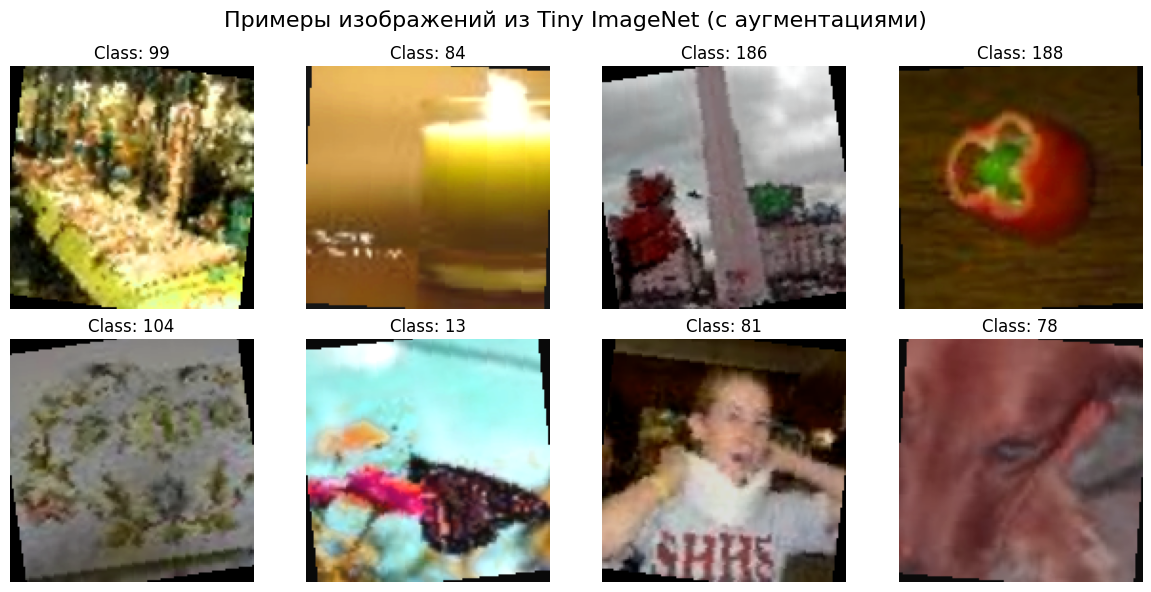

Размер батча: torch.Size([8, 3, 128, 128])
Диапазон значений: [-2.118, 2.640]
Метки классов: [99, 84, 186, 188, 104, 13, 81, 78]
Всего классов в датасете: 200
Примеры названий классов: ['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582', 'n01641577', 'n02802426', 'n09246464']


In [3]:
images, labels = next(iter(train_loader_big))

def denormalize(img_tensor):
    """Вернём изображение из нормализованного диапазона в [0,1]"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    img = img_tensor.permute(1, 2, 0) * std + mean
    return img.clamp(0, 1)

images_vis = images.permute(0, 2, 3, 1)

images_vis = torch.stack([denormalize(img) for img in images])

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images_vis[i])
    plt.title(f"Class: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Примеры изображений из Tiny ImageNet (с аугментациями)", fontsize=16)
plt.tight_layout()
plt.show()

print(f"Размер батча: {images.shape}")
print(f"Диапазон значений: [{images.min():.3f}, {images.max():.3f}]")
print(f"Метки классов: {labels.tolist()}")
print(f"Всего классов в датасете: {len(train_dataset_big.class_names)}")
print(f"Примеры названий классов: {train_dataset_big.class_names[:8]}")

## Стратификация 

Стратификация была сделана в дз ко второму семинару, возмем ее оттуда. Делается стратификация по эмбеддингам

In [ ]:
def extract_and_cluster_embeddings(subset_samples, selected_classes, n_clusters=10, 
                                   batch_size=64, device='auto', return_visualization=False):
    """
    Извлекает эмбеддинги(resnet50), выполняет кластеризацию(K-means) и стратификацию
    
    Args:
        subset_samples: список пар (путь к изображению, метка)
        selected_classes: список выбранных классов
        n_clusters: количество кластеров для K-means
        batch_size: размер батча для извлечения эмбеддингов
        device: 'auto', 'cuda' или 'cpu'
        return_visualization: возвращать ли данные для визуализации (PCA)
    
    Returns:
        train_dataset: датасет для тренировки
        val_dataset: датасет для валидации
        (optional) vis_data: данные для визуализации если return_visualization=True
    """
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

    if device == 'auto':
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        device = torch.device(device)
        
    # Загружаем ResNet50
    resnet = models.resnet50(pretrained=True)
    resnet = resnet.to(device)
    resnet.eval()
    
    # Feature extractor (без последнего слоя)
    feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
    feature_extractor = feature_extractor.to(device)
    
    def extract_embeddings(images):
        """Извлекает эмбеддинги из батча изображений"""
        with torch.no_grad():
            x = feature_extractor(images)      # [B, 2048, 1, 1]
            x = x.view(x.size(0), -1)          # [B, 2048]
        return x
    
    # Создаем датасет и загрузчик
    train_subset_dataset_temp = CustomDataset(subset_samples, transform=train_transform)
    temp_loader = DataLoader(train_subset_dataset_temp, batch_size=batch_size, shuffle=False)
    
    # Извлекаем эмбеддинги
    all_embeddings = []
    all_labels = []
    
    for images, labels in tqdm(temp_loader, desc="Извлечение эмбедингов"):
        images = images.to(device)
        emb = extract_embeddings(images)
        all_embeddings.append(emb.cpu())
        all_labels.append(labels)
    
    all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    
    print(f"Извлечено {all_embeddings.shape[0]} эмбеддингов, размерность: {all_embeddings.shape[1]}")
    
    # Кластеризация K-means
    print(f"\nКластеризация (K={n_clusters})...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    pseudo_labels = kmeans.fit_predict(all_embeddings)
    
    # Анализ соответствия кластеров и классов
    print("Соответствие кластеров исходным классам:")
    cluster_class_mapping = {}
    for cluster_id in range(n_clusters):
        cluster_indices = np.where(pseudo_labels == cluster_id)[0]
        if len(cluster_indices) > 0:
            cluster_classes = all_labels[cluster_indices]
            most_common = Counter(cluster_classes).most_common(1)[0]
            cluster_class_mapping[cluster_id] = most_common
            print(f"  Кластер {cluster_id}: {len(cluster_indices)} образцов, "
                  f"класс {most_common[0]} ({most_common[1]} образцов)")
    
    # Метрики качества кластеризации
    ari_score = adjusted_rand_score(all_labels, pseudo_labels)
    nmi_score = normalized_mutual_info_score(all_labels, pseudo_labels)
    print(f"\nКачество кластеризации:")
    print(f"  Adjusted Rand Index: {ari_score:.3f}")
    print(f"  Normalized Mutual Information: {nmi_score:.3f}")
    
    # Стратификация по кластерам
    print("\nСтратификация по кластерам...")
    sss_embedding = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx_embedding, val_idx_embedding = next(
        sss_embedding.split(subset_samples, pseudo_labels)
    )
    
    train_samples_embedding = [subset_samples[i] for i in train_idx_embedding]
    val_samples_embedding = [subset_samples[i] for i in val_idx_embedding]
    
    print(f"  Train: {len(train_samples_embedding)} образов")
    print(f"  Val: {len(val_samples_embedding)} образцов")
    
    # Анализ распределения
    def analyze_split(samples, name):
        labels = [label for _, label in samples]
        class_counts = Counter(labels)
        print(f"\n{name}:")
        for class_id in selected_classes:
            count = class_counts.get(class_id, 0)
            percentage = count / len(labels) * 100
            print(f"  Класс {class_id}: {count} ({percentage:.1f}%)")
    
    analyze_split(train_samples_embedding, "Train распределение")
    analyze_split(val_samples_embedding, "Val распределение")
    
    # Создаем финальные датасеты
    train_dataset = CustomDataset(train_samples_embedding, transform=train_transform)
    val_dataset = CustomDataset(val_samples_embedding, transform=val_transform)
    
    # Возвращаем результат
    if return_visualization:
        # PCA для визуализации
        pca = PCA(n_components=2, random_state=42)
        emb_2d = pca.fit_transform(all_embeddings)
        
        vis_data = {
            'emb_2d': emb_2d,
            'all_labels': all_labels,
            'pseudo_labels': pseudo_labels,
            'all_embeddings': all_embeddings,
            'cluster_class_mapping': cluster_class_mapping,
            'pca_variance': pca.explained_variance_ratio_,
            'selected_classes': selected_classes,
            'n_clusters': n_clusters
        }
        
        return train_dataset, val_dataset, vis_data
    
    return train_dataset, val_dataset


# Функция для визуализации
def visualize_clustering_results(vis_data):
    """Визуализация результатов кластеризации"""
    
    emb_2d = vis_data['emb_2d']
    all_labels = vis_data['all_labels']
    pseudo_labels = vis_data['pseudo_labels']
    selected_classes = vis_data['selected_classes']
    n_clusters = vis_data['n_clusters']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # По кластерам
    colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    for cluster in range(n_clusters):
        indices = np.where(pseudo_labels == cluster)[0]
        if len(indices) > 0:
            ax1.scatter(emb_2d[indices, 0], emb_2d[indices, 1], 
                       c=[colors[cluster]], label=f'Cluster {cluster}', s=20, alpha=0.7)
    
    ax1.set_title(f"Кластеризация (K={n_clusters})")
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # По исходным классам
    class_colors = plt.cm.Set1(np.linspace(0, 1, len(selected_classes)))
    for i, class_id in enumerate(selected_classes):
        indices = np.where(all_labels == class_id)[0]
        if len(indices) > 0:
            ax2.scatter(emb_2d[indices, 0], emb_2d[indices, 1], 
                       c=[class_colors[i]], label=f'Class {class_id}', s=20, alpha=0.7)
    
    ax2.set_title("Исходные классы")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"PCA объясняет {vis_data['pca_variance'].sum():.3f} дисперсии")
    print("Чем выше значения, тем лучше кластеризация соответствует исходным классам")

## Реализация архитектуры

В начале делается начальный блок который быстро уменьшает размер картинки.

Далее 4 стадии:

1: два базовых residual‑блока (BasicBlock) на 64 каналах с downsampling без изменения разрешения.

2: два BasicBlock на 128 каналах с downsampling.

3: два bottleneck‑блока 64 -> 128 с downsampling.

4: два bottleneck‑блока 128 -> 256 с downsampling.


Финал: Global Average Pooling -> Flatten -> Dropout -> один полносвязный слой (Linear(512, num_classes)).

Решил попробовать найти реализации BottleNeck и попробовать поисполькозовать ее для обучения сети.

In [5]:
class BasicBlock(nn.Module):
    """
    Базовый блок ResNet с residual connection
    
    Args:
        in_channels (int): количество входных каналов
        out_channels (int): количество выходных каналов
        stride (int): шаг свертки (по умолчанию 1)
        downsample (nn.Module): слой для изменения размерности (если нужно)
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Identity()
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

        # Тут в сверточных слоях ставят bias = False, так как сдвиг батчнорма его покрывает
        # Также в relu ставят inplace=True

    def forward(self, x):
        x0 = self.downsample(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += x0
        out = self.relu(out)

        return out

basic_block = BasicBlock(64, 128, 2) # из 64 каналов получаем 128 каналов
test_input = torch.randn(8, 64, 32, 32)

output = basic_block(test_input)
print(output.shape)

torch.Size([8, 128, 16, 16])


In [6]:
class BottleneckBlock(nn.Module):
    """
    Bottleneck блок (1x1 -> 3x3 -> 1x1)
    in_channels -> out_channels, с downsample если размерности не совпадают
    """
    expansion = 4  # как в ResNet: out_channels = mid_channels * 4

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        mid_channels = out_channels // self.expansion

        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)

        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)

        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        self.downsample = nn.Identity()
        if in_channels != out_channels:
           self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        x0 = self.downsample(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out += x0

        out = self.relu(out)

        return out

bottleneck_block = BottleneckBlock(64, 256, stride=1)
test_input = torch.randn(8, 64, 32, 32)

output = bottleneck_block(test_input)
print(output.shape)

torch.Size([8, 256, 32, 32])


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleModifyNet(nn.Module):
    def __init__(self, num_classes=200,  dropout_rate=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.basic_block_1_0 = BasicBlock(64, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, stride=2)
        self.basic_block_2_1 = BasicBlock(128, 128)

        self.bottle_neck_block_3_0 = BottleneckBlock(128, 256, stride=2)
        self.bottle_neck_block_3_1 = BottleneckBlock(256, 256)

        self.bottle_neck_block_4_0 = BottleneckBlock(256, 512, stride=2)
        self.bottle_neck_block_4_1 = BottleneckBlock(512, 512)

        self.adapavgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout_rate) 
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        
        x = self.basic_block_1_1(self.basic_block_1_0(x))
        
        x = self.basic_block_2_1(self.basic_block_2_0(x))

        x = self.bottle_neck_block_3_1(self.bottle_neck_block_3_0(x))

        x = self.bottle_neck_block_4_1(self.bottle_neck_block_4_0(x))

        x = self.fc(self.dropout(self.flatten(self.adapavgpool(x))))
        
        return x


model = SimpleModifyNet(num_classes=10)
test_input = torch.randn(1, 3, 128, 128)

output = model(test_input)
print(f"Размеры выхода: {output.shape}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")

Размеры выхода: torch.Size([1, 10])
Всего параметров: 1,505,994
Обучаемых параметров: 1,505,994


## Функции для обучения и графиков

In [8]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Функция для одной эпохи обучения
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        train_loss: средняя потеря за эпоху
        train_acc: средняя точность за эпоху
    """
    model.train()  # Переводим модель в режим обучения
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc="Тренировка ")
    
    for batch_idx, (data, target) in enumerate(pbar):
        data.to(device)
        target.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()
        
        # Предсказания модели
        outputs = model(data)
        
        # Вычисляем loss
        loss = criterion(outputs, target)
        
        # Вычисляем градиенты
        loss.backward()
        
        # Обновляем веса
        optimizer.step()
        
        # Собираем статистику
        running_loss += loss.item()

        # Вычисляем accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)
        
        avg_loss = running_loss / total
        avg_acc = 100 * correct / total
        pbar.set_postfix({
            'loss': f'{avg_loss:.4f}',
            'acc': f'{avg_acc:.2f}%'
        })

    train_loss = running_loss / total if total > 0 else 0
    train_acc = 100 * correct / total if total > 0 else 0
    
    return train_loss, train_acc


def validate_epoch(model, val_loader, criterion, device):
    """
    Функция для валидации одной эпохи
    
    Args:
        model: модель для валидации
        val_loader: DataLoader с валидационными данными
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        val_loss: средняя потеря за эпоху
        val_acc: средняя точность за эпоху
    """
    model.eval()  # Переводим модель в режим оценки
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Отключаем вычисление градиентов
        pbar = tqdm(val_loader, desc="Валидация  ")
        
        for batch_idx, (data, target) in enumerate(pbar):
            data = data.to(device)
            target = target.to(device)
            
            # Предсказания модели
            outputs = model(data)
            
            # Вычисляем loss
            loss = criterion(outputs, target)
            
            # Собираем статистику
            running_loss += loss.item()

            # Вычисляем accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)
            
            # Обновляем прогресс-бар
            avg_loss = running_loss / total
            avg_acc = 100 * correct / total
            pbar.set_postfix({
                'loss': f'{avg_loss:.4f}',
                'acc': f'{avg_acc:.2f}%'
            })

    val_loss = running_loss / total if total > 0 else 0
    val_acc = 100 * correct / total if total > 0 else 0
    
    return val_loss, val_acc

def print_model_summary_and_plot(history, model):
    """
    Выводит информацию о модели и строит графики
    
    Args:
        history: история обучения (словарь)
        model: обученная модель
    """
    import matplotlib.pyplot as plt
    
    print("="*60)
    print("ИНФОРМАЦИЯ О МОДЕЛИ И РЕЗУЛЬТАТЫ ОБУЧЕНИЯ")
    print("="*60)
    
    print("\n1. АРХИТЕКТУРА МОДЕЛИ:")
    print("-" * 30)
    print(model)
    
    print("\n2. ПАРАМЕТРЫ МОДЕЛИ:")
    print("-" * 30)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Всего параметров: {total_params:,}")
    print(f"Обучаемых параметров: {trainable_params:,}")
    
    print("\n3. ФИНАЛЬНЫЕ МЕТРИКИ:")
    print("-" * 30)
    print(f"Best Validation Accuracy: {max(history['val_acc']):.2f}%")
    print(f"Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")
    
    # Графики
    print("\n4. ГРАФИКИ ОБУЧЕНИЯ:")
    print("-" * 30)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # График Accuracy
    ax1.plot(history['train_acc'], label='Train', color='blue', linewidth=2)
    ax1.plot(history['val_acc'], label='Validation', color='red', linewidth=2)
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График Loss
    ax2.plot(history['train_loss'], label='Train', color='blue', linewidth=2)
    ax2.plot(history['val_loss'], label='Validation', color='red', linewidth=2)
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001, 
                optimizer_type='adam', device='cpu', save_file_name='best_model.pth'):
    """
    Полный цикл обучения модели используется criterion = nn.CrossEntropyLoss()
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        val_loader: DataLoader с валидационными данными
        num_epochs: количество эпох
        learning_rate: скорость обучения
        optimizer_type: 'adam' или 'sgd'
        device: устройство для обучения ('cpu' или 'cuda')
    
    Returns:
        history: словарь с историей обучения
        best_model: лучшая модель (по accuracy на валидации)
    """
    model = model.to(device)
    print(f"Параметры модели: {sum(p.numel() for p in model.parameters()):,}")
    
    if optimizer_type.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        print(f"Optimizer: Adam, lr: {learning_rate}")
    elif optimizer_type.lower() == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        print(f"Optimizer: SGD, lr: {learning_rate}")
    else:
        raise ValueError("optimizer_type должен быть 'adam' или 'sgd'")
    
    criterion = nn.CrossEntropyLoss()
    
    history = {
        'epoch': [],
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Для сохранения лучшей модели
    best_val_acc = 0.0
    best_model_state = None
    best_epoch = 0
    
    for epoch in range(num_epochs):
        print(f"\nЭпоха {epoch + 1} из {num_epochs}")
        
        train_loss, train_acc = train_epoch(
            model=model,
            train_loader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            device=device
        )
        
        val_loss, val_acc = validate_epoch(
            model=model,
            val_loader=val_loader,
            criterion=criterion,
            device=device
        )
        
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"\nЭпоха {epoch + 1} Вывод:")
        print(f"Training  |Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
        print(f"Validation|Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")
        
        # Сохраняем лучшую модель
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            best_model_state = model.state_dict().copy()
            
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, save_file_name)
    
    print("Все!")
    print(f"Лучшая acc на валидации   : {best_val_acc:.2f}% это на эпохе {best_epoch}")
    print(f"Финальная acc на трейне   : {history['train_acc'][-1]:.2f}%")
    print(f"Финальная acc на валидации: {history['val_acc'][-1]:.2f}%")
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return history, model, best_val_acc

## Запуск скрипта

In [9]:
num_classes = 10
selected_classes = [i for i in range(0, num_classes)] # чтобы сразу класс соответсвовал индеку, иначе пришлось бы чет делать с нумерацией

subset_samples = [s for s in train_dataset_big.samples if s[1] in selected_classes] # выбраю те, у которых label из selected_classes
test_subset_samples = [s for s in val_dataset_big.samples if s[1] in selected_classes] # валидация идет на тест

print(f"Используем {len(subset_samples)} изображений из {len(selected_classes)} классов")
print(f"Выбранные классы: {selected_classes}")

# Стратификация
train_dataset, val_dataset, vis_data = extract_and_cluster_embeddings(
    subset_samples=subset_samples,
    selected_classes=selected_classes,
    n_clusters=15,
    batch_size=64,
    return_visualization=True
)

Используем 5000 изображений из 10 классов
Выбранные классы: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


c:\Users\User\anaconda3\envs\neural_networks\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\neural_networks\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Извлечение эмбедингов: 100%|██████████| 79/79 [00:56<00:00,  1.39it/s]


Извлечено 5000 эмбеддингов, размерность: 2048

Кластеризация (K=15)...
Соответствие кластеров исходным классам:
  Кластер 0: 106 образцов, класс 5 (102 образцов)
  Кластер 1: 682 образцов, класс 6 (289 образцов)
  Кластер 2: 325 образцов, класс 7 (169 образцов)
  Кластер 3: 615 образцов, класс 3 (252 образцов)
  Кластер 4: 321 образцов, класс 1 (125 образцов)
  Кластер 5: 240 образцов, класс 8 (199 образцов)
  Кластер 6: 280 образцов, класс 1 (116 образцов)
  Кластер 7: 257 образцов, класс 4 (234 образцов)
  Кластер 8: 195 образцов, класс 4 (156 образцов)
  Кластер 9: 494 образцов, класс 3 (127 образцов)
  Кластер 10: 518 образцов, класс 5 (244 образцов)
  Кластер 11: 208 образцов, класс 0 (181 образцов)
  Кластер 12: 222 образцов, класс 8 (219 образцов)
  Кластер 13: 151 образцов, класс 0 (151 образцов)
  Кластер 14: 386 образцов, класс 7 (216 образцов)

Качество кластеризации:
  Adjusted Rand Index: 0.242
  Normalized Mutual Information: 0.404

Стратификация по кластерам...
  Train: 

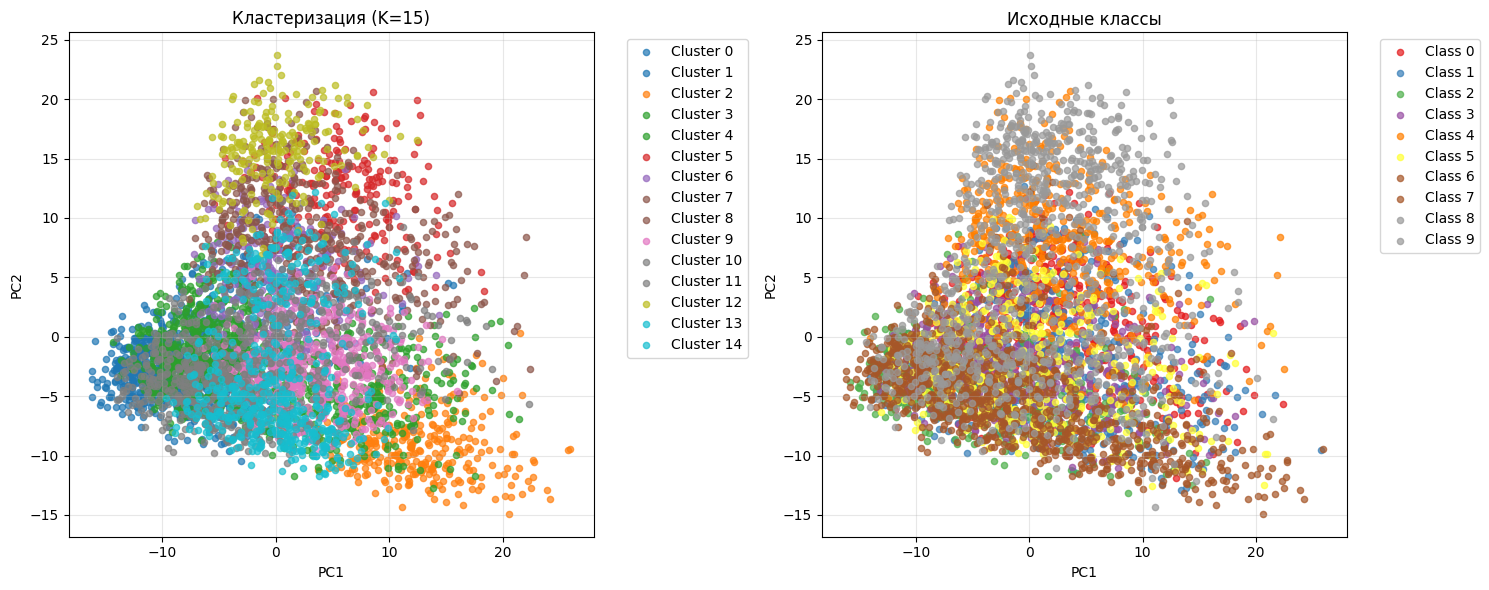

PCA объясняет 0.144 дисперсии
Чем выше значения, тем лучше кластеризация соответствует исходным классам


In [10]:
visualize_clustering_results(vis_data)

In [11]:
model = SimpleModifyNet(num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

print(f"Train : {len(train_loader)} бачей, {len(train_dataset)} изображений")
print(f"Val   : {len(val_loader)} бачей, {len(val_dataset)} изображений")

history, model, best_val_acc = train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    num_epochs=40, 
    learning_rate=0.001, 
    optimizer_type='adam', 
    device=device,
    save_file_name='best_model_classifier.pth'
)

Train : 63 бачей, 4000 изображений
Val   : 16 бачей, 1000 изображений
Параметры модели: 1,505,994
Optimizer: Adam, lr: 0.001

Эпоха 1 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  6.05it/s, loss=0.0358, acc=31.60%]



Эпоха 1 Вывод:
Training  |Loss: 0.0332 | Acc: 25.32%
Validation|Loss: 0.0358 | Acc: 31.60%

Эпоха 2 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.45it/s, loss=0.0273, acc=39.30%]



Эпоха 2 Вывод:
Training  |Loss: 0.0290 | Acc: 35.52%
Validation|Loss: 0.0273 | Acc: 39.30%

Эпоха 3 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.70it/s, loss=0.0257, acc=45.90%]



Эпоха 3 Вывод:
Training  |Loss: 0.0266 | Acc: 41.17%
Validation|Loss: 0.0257 | Acc: 45.90%

Эпоха 4 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.73it/s, loss=0.0292, acc=38.70%]



Эпоха 4 Вывод:
Training  |Loss: 0.0256 | Acc: 44.65%
Validation|Loss: 0.0292 | Acc: 38.70%

Эпоха 5 из 40


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.06it/s, loss=0.0267, acc=48.60%]



Эпоха 5 Вывод:
Training  |Loss: 0.0237 | Acc: 47.25%
Validation|Loss: 0.0267 | Acc: 48.60%

Эпоха 6 из 40


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.10it/s, loss=0.0237, acc=49.70%]



Эпоха 6 Вывод:
Training  |Loss: 0.0224 | Acc: 51.95%
Validation|Loss: 0.0237 | Acc: 49.70%

Эпоха 7 из 40


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.02it/s, loss=0.0245, acc=48.80%]



Эпоха 7 Вывод:
Training  |Loss: 0.0215 | Acc: 54.00%
Validation|Loss: 0.0245 | Acc: 48.80%

Эпоха 8 из 40


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.00it/s, loss=0.0240, acc=52.20%]



Эпоха 8 Вывод:
Training  |Loss: 0.0211 | Acc: 54.48%
Validation|Loss: 0.0240 | Acc: 52.20%

Эпоха 9 из 40


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.03it/s, loss=0.0219, acc=54.60%]



Эпоха 9 Вывод:
Training  |Loss: 0.0198 | Acc: 56.83%
Validation|Loss: 0.0219 | Acc: 54.60%

Эпоха 10 из 40


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.04it/s, loss=0.0221, acc=53.40%]



Эпоха 10 Вывод:
Training  |Loss: 0.0198 | Acc: 57.17%
Validation|Loss: 0.0221 | Acc: 53.40%

Эпоха 11 из 40


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.56it/s, loss=0.0219, acc=52.30%]



Эпоха 11 Вывод:
Training  |Loss: 0.0186 | Acc: 59.98%
Validation|Loss: 0.0219 | Acc: 52.30%

Эпоха 12 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  6.13it/s, loss=0.0188, acc=60.90%]



Эпоха 12 Вывод:
Training  |Loss: 0.0184 | Acc: 59.65%
Validation|Loss: 0.0188 | Acc: 60.90%

Эпоха 13 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.94it/s, loss=0.0197, acc=59.40%]



Эпоха 13 Вывод:
Training  |Loss: 0.0178 | Acc: 61.42%
Validation|Loss: 0.0197 | Acc: 59.40%

Эпоха 14 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.88it/s, loss=0.0203, acc=54.80%]



Эпоха 14 Вывод:
Training  |Loss: 0.0179 | Acc: 61.33%
Validation|Loss: 0.0203 | Acc: 54.80%

Эпоха 15 из 40


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.12it/s, loss=0.0179, acc=60.20%]



Эпоха 15 Вывод:
Training  |Loss: 0.0169 | Acc: 63.40%
Validation|Loss: 0.0179 | Acc: 60.20%

Эпоха 16 из 40


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.04it/s, loss=0.0218, acc=54.80%]



Эпоха 16 Вывод:
Training  |Loss: 0.0161 | Acc: 65.15%
Validation|Loss: 0.0218 | Acc: 54.80%

Эпоха 17 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.99it/s, loss=0.0189, acc=60.00%]



Эпоха 17 Вывод:
Training  |Loss: 0.0158 | Acc: 65.60%
Validation|Loss: 0.0189 | Acc: 60.00%

Эпоха 18 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  4.00it/s, loss=0.0175, acc=63.40%]



Эпоха 18 Вывод:
Training  |Loss: 0.0158 | Acc: 65.15%
Validation|Loss: 0.0175 | Acc: 63.40%

Эпоха 19 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.78it/s, loss=0.0180, acc=63.80%]



Эпоха 19 Вывод:
Training  |Loss: 0.0146 | Acc: 67.95%
Validation|Loss: 0.0180 | Acc: 63.80%

Эпоха 20 из 40


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.03it/s, loss=0.0227, acc=56.10%]



Эпоха 20 Вывод:
Training  |Loss: 0.0150 | Acc: 67.70%
Validation|Loss: 0.0227 | Acc: 56.10%

Эпоха 21 из 40


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.06it/s, loss=0.0196, acc=60.10%]



Эпоха 21 Вывод:
Training  |Loss: 0.0140 | Acc: 69.58%
Validation|Loss: 0.0196 | Acc: 60.10%

Эпоха 22 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.95it/s, loss=0.0219, acc=57.70%]



Эпоха 22 Вывод:
Training  |Loss: 0.0141 | Acc: 69.62%
Validation|Loss: 0.0219 | Acc: 57.70%

Эпоха 23 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.91it/s, loss=0.0184, acc=63.30%]



Эпоха 23 Вывод:
Training  |Loss: 0.0136 | Acc: 70.95%
Validation|Loss: 0.0184 | Acc: 63.30%

Эпоха 24 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.71it/s, loss=0.0184, acc=62.60%]



Эпоха 24 Вывод:
Training  |Loss: 0.0136 | Acc: 70.85%
Validation|Loss: 0.0184 | Acc: 62.60%

Эпоха 25 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.97it/s, loss=0.0156, acc=67.10%]



Эпоха 25 Вывод:
Training  |Loss: 0.0134 | Acc: 70.28%
Validation|Loss: 0.0156 | Acc: 67.10%

Эпоха 26 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.96it/s, loss=0.0177, acc=63.10%]



Эпоха 26 Вывод:
Training  |Loss: 0.0133 | Acc: 70.72%
Validation|Loss: 0.0177 | Acc: 63.10%

Эпоха 27 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.99it/s, loss=0.0196, acc=61.70%]



Эпоха 27 Вывод:
Training  |Loss: 0.0121 | Acc: 73.85%
Validation|Loss: 0.0196 | Acc: 61.70%

Эпоха 28 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.96it/s, loss=0.0169, acc=66.00%]



Эпоха 28 Вывод:
Training  |Loss: 0.0116 | Acc: 74.90%
Validation|Loss: 0.0169 | Acc: 66.00%

Эпоха 29 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.64it/s, loss=0.0228, acc=59.10%]



Эпоха 29 Вывод:
Training  |Loss: 0.0112 | Acc: 75.08%
Validation|Loss: 0.0228 | Acc: 59.10%

Эпоха 30 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.87it/s, loss=0.0178, acc=64.80%]



Эпоха 30 Вывод:
Training  |Loss: 0.0113 | Acc: 75.55%
Validation|Loss: 0.0178 | Acc: 64.80%

Эпоха 31 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.67it/s, loss=0.0201, acc=62.50%]



Эпоха 31 Вывод:
Training  |Loss: 0.0117 | Acc: 74.92%
Validation|Loss: 0.0201 | Acc: 62.50%

Эпоха 32 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.73it/s, loss=0.0159, acc=69.40%]



Эпоха 32 Вывод:
Training  |Loss: 0.0108 | Acc: 76.72%
Validation|Loss: 0.0159 | Acc: 69.40%

Эпоха 33 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.87it/s, loss=0.0181, acc=65.70%]



Эпоха 33 Вывод:
Training  |Loss: 0.0100 | Acc: 77.90%
Validation|Loss: 0.0181 | Acc: 65.70%

Эпоха 34 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.85it/s, loss=0.0203, acc=63.70%]



Эпоха 34 Вывод:
Training  |Loss: 0.0105 | Acc: 77.50%
Validation|Loss: 0.0203 | Acc: 63.70%

Эпоха 35 из 40


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.01it/s, loss=0.0170, acc=67.60%]



Эпоха 35 Вывод:
Training  |Loss: 0.0103 | Acc: 77.33%
Validation|Loss: 0.0170 | Acc: 67.60%

Эпоха 36 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.91it/s, loss=0.0237, acc=60.20%]



Эпоха 36 Вывод:
Training  |Loss: 0.0097 | Acc: 78.83%
Validation|Loss: 0.0237 | Acc: 60.20%

Эпоха 37 из 40


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.91it/s, loss=0.0185, acc=66.00%]



Эпоха 37 Вывод:
Training  |Loss: 0.0090 | Acc: 79.83%
Validation|Loss: 0.0185 | Acc: 66.00%

Эпоха 38 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.72it/s, loss=0.0168, acc=68.70%]



Эпоха 38 Вывод:
Training  |Loss: 0.0087 | Acc: 81.20%
Validation|Loss: 0.0168 | Acc: 68.70%

Эпоха 39 из 40


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.24it/s, loss=0.0169, acc=69.20%]



Эпоха 39 Вывод:
Training  |Loss: 0.0087 | Acc: 81.85%
Validation|Loss: 0.0169 | Acc: 69.20%

Эпоха 40 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.48it/s, loss=0.0209, acc=66.10%]


Эпоха 40 Вывод:
Training  |Loss: 0.0084 | Acc: 81.05%
Validation|Loss: 0.0209 | Acc: 66.10%
Все!
Лучшая acc на валидации   : 69.40% это на эпохе 32
Финальная acc на трейне   : 81.05%
Финальная acc на валидации: 66.10%


ИНФОРМАЦИЯ О МОДЕЛИ И РЕЗУЛЬТАТЫ ОБУЧЕНИЯ

1. АРХИТЕКТУРА МОДЕЛИ:
------------------------------
SimpleModifyNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (basic_block_1_0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Identity()
  )
  (basic_block_1_1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn

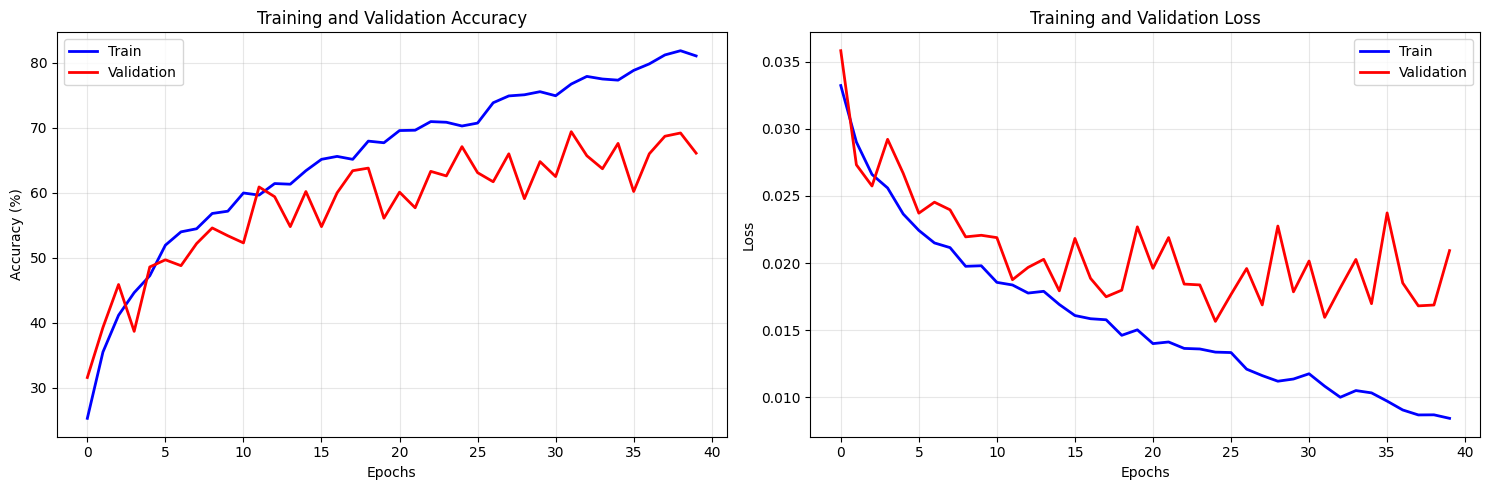

In [12]:
print_model_summary_and_plot(history, model)

Модель обучалась 40 эпох. Точность на трейне стабильно росла. Валидационная точность достигла 69.40% на эпохе 32, что является приемлемым результатом при таком количестве параметров. Разрыв между трейном и валидацией (~12–15%) указывает на умеренное переобучение, особенно после эпохи. Результы на валидации хуже, чем в семинаре 2, возможно это потому что я решил использовать bottleneck, где в этом не было большой необходимости, ведь размер задачи не сильно большой.

# Часть 2. Базовая U-Net на "Луне"

## Построение датасета и аугментация

In [13]:
class MoonSegmentationDataset(Dataset):

    def __init__(self, root_dir, image_folder='render', mask_folder='ground', 
                 image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        images_dir = os.path.join(root_dir, 'images', image_folder)
        masks_dir = os.path.join(root_dir, 'images', mask_folder)
        
        if image_ids is None:
            all_images = os.listdir(images_dir)
            self.image_ids = [img.replace('.png', '') for img in all_images if img.endswith('.png')]
        else:
            self.image_ids = image_ids
        
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        image_path = os.path.join(self.root_dir, 'images', self.image_folder, f"{image_id}.png")
        
        # Для масок убираем префикс "render" если он есть
        # Например: render0001 - 0001
        mask_id = image_id.replace('render', '') if 'render' in image_id else image_id
        mask_path = os.path.join(self.root_dir, 'images', self.mask_folder, f"ground{mask_id}.png")
        
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Так как используем opencv, то не забываем преводить из BGR в RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Нормализуем бинарную маску к [0, 1]
        # 0 = фон, 1 = камни
        mask = (mask > 0).astype(np.float32)
        
        # Применяем аугментации
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # Применяем предобработку
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask

# Аугментации для обучения
train_augmentation = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 7)),
        A.GaussNoise(var_limit=(10.0, 50.0)),
        A.MedianBlur(blur_limit=5),
    ], p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
])

preprocessing = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_augmentation = A.Compose([
    A.Resize(128, 128),
])

c:\Users\User\anaconda3\envs\neural_networks\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_2100\2898020034.py:65: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0)),


## Формирование даталоадеров

In [14]:
from sklearn.model_selection import train_test_split

# Путь к данным
DATA_ROOT = "data/MOON_SEGMENTATION_BINARY/"

images_dir = os.path.join(DATA_ROOT, 'images', 'render')
all_images = [img.replace('.png', '') for img in os.listdir(images_dir) if img.endswith('.png')][:100]

print(f"Всего изображений: {len(all_images)}")

train_ids, val_ids = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Train: {len(train_ids)} изображений")
print(f"Val: {len(val_ids)} изображений")

train_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=train_ids,
    augmentation=train_augmentation,
    preprocessing=preprocessing
)

val_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=val_ids,
    augmentation=val_augmentation,
    preprocessing=preprocessing
)

BATCH_SIZE = 4
NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Батчей в train: {len(train_loader)}")
print(f"Батчей в val: {len(val_loader)}")

Всего изображений: 100
Train: 80 изображений
Val: 20 изображений
Батчей в train: 20
Батчей в val: 5


## Визуализация

c:\Users\User\anaconda3\envs\neural_networks\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Размер батча изображений: torch.Size([4, 3, 128, 128])
Размер батча масок: torch.Size([4, 128, 128])


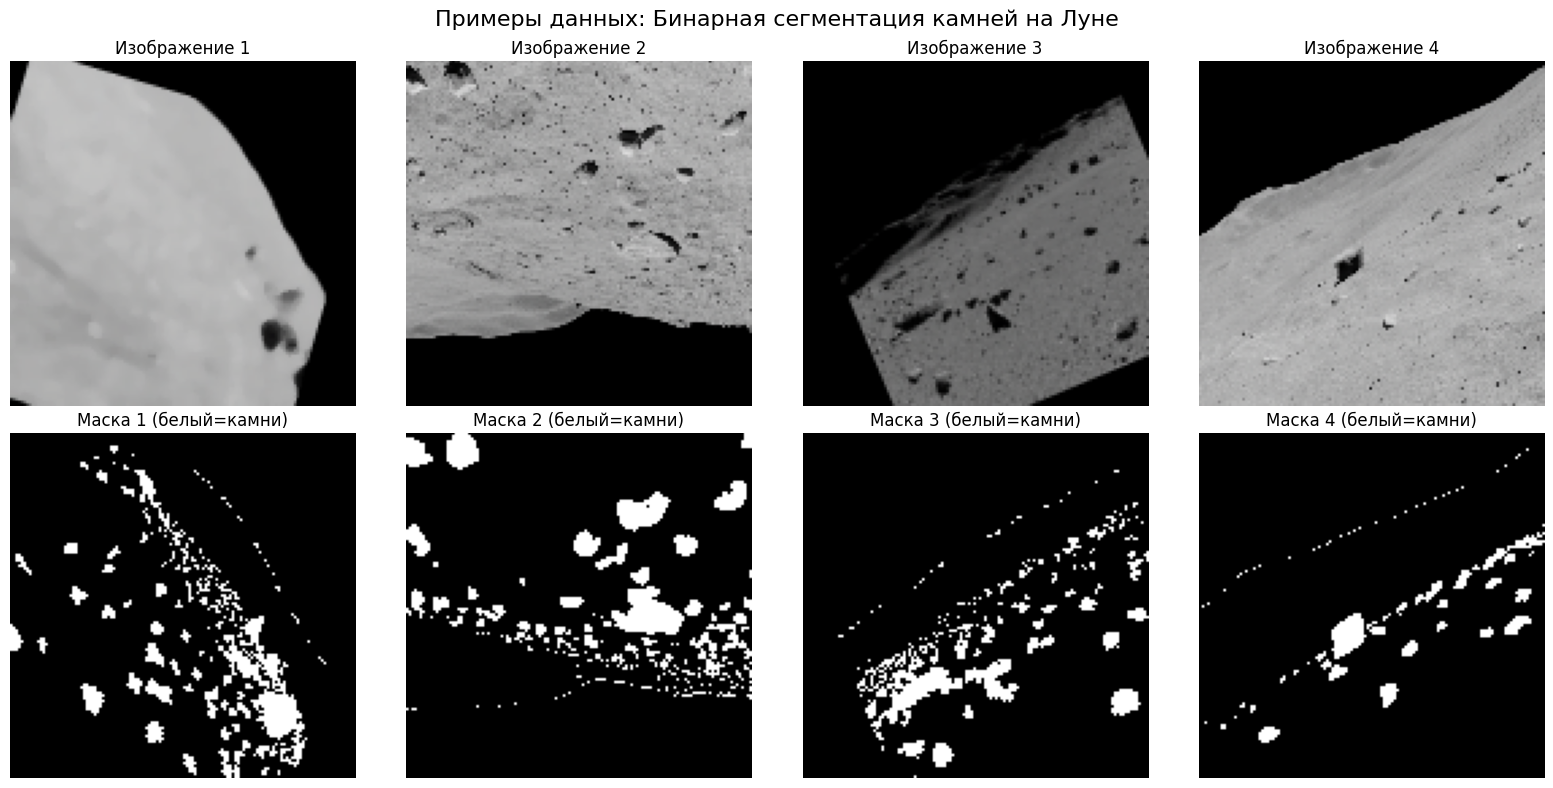

In [15]:
def denormalize(img_tensor):
    """Денормализация изображения для визуализации"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

images, masks = next(iter(train_loader))

print(f"Размер батча изображений: {images.shape}")
print(f"Размер батча масок: {masks.shape}")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(min(4, len(images))):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    mask = masks[i].numpy()
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Изображение {i+1}")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f"Маска {i+1} (белый=камни)")
    axes[1, i].axis('off')

plt.suptitle("Примеры данных: Бинарная сегментация камней на Луне", fontsize=16)
plt.tight_layout()
plt.show()

## Построение модели

**U-Net** - это архитектура для семантической сегментации, предложенная в 2015 году.

Основные компоненты:
1. **Encoder (Downsampling)** - сжимает изображение, извлекая признаки
2. **Bottleneck** - самый глубокий слой с максимальным количеством каналов
3. **Decoder (Upsampling)** - восстанавливает разрешение
4. **Skip Connections** - соединяют encoder и decoder для сохранения деталей

In [16]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)


In [17]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 128]):
        super(UNet, self).__init__()
        
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        prev_channels = in_channels
        for feature in features:
            self.encoder_blocks.append(DoubleConv(prev_channels, feature))
            prev_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                DoubleConv(feature * 2, feature)
            )

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Параметров: {total_params:,}")
        print(f"Уровней encoder: {len(features)}")
        print(f"Конфигурация каналов: {features}")
    
    def forward(self, x):

        skip_connections = []

        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)
            
            skip_connection = skip_connections[idx // 2]
            
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], 
                                mode='bilinear', align_corners=True)
            
            x = torch.cat([skip_connection, x], dim=1)
            
            x = self.decoder_blocks[idx + 1](x)

        output = self.final_conv(x)
        
        return output


model = UNet(in_channels=3, out_channels=1, features=[16, 32, 64, 128])

test_input = torch.randn(1, 3, 128, 128)
test_output = model(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

Параметров: 1,944,049
Уровней encoder: 4
Конфигурация каналов: [16, 32, 64, 128]
   Вход:  torch.Size([1, 3, 128, 128])
   Выход: torch.Size([1, 1, 128, 128])


Базовые каналы на первом уровне: 16 так как в других случая выходит много параметров. Показалось, что это самый простой способ уменьшить количество параметров, поэтому решил реализовать так

In [18]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")

Всего параметров: 1,944,049
Обучаемых параметров: 1,944,049


## Функции потерь и метрики для сегментации

Метрики сегментации:
- **Dice Loss** - популярная функция потерь для сегментации
- **IoU (Intersection over Union)** - метрика качества сегментации
- **Pixel Accuracy** - точность предсказания пикселей


In [19]:
class DiceLoss(nn.Module):
    """
    Dice Loss для бинарной сегментации
    
    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        predictions = torch.sigmoid(predictions)
        
        # Flatten
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Dice coefficient
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        # Dice loss
        return 1 - dice


class CombinedLoss(nn.Module):

    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    
    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)
        
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


def dice_coefficient(predictions, targets, threshold=0.5, smooth=1e-6):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    intersection = (predictions * targets).sum()
    dice = (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)
    
    return dice.item()


def iou_score(predictions, targets, threshold=0.5, smooth=1e-6):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.item()


def pixel_accuracy(predictions, targets, threshold=0.5):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    correct = (predictions == targets).float().sum()
    total = targets.numel()
    
    return (correct / total).item()

## Функции для обучения

In [20]:
def train_epoch(model, train_loader, criterion, optimizer, device):

    model.train()
    
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_acc = 0.0
    
    pbar = tqdm(train_loader, desc="Training")
    
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = pixel_accuracy(outputs, masks)
        
        running_loss += loss.item()
        running_dice += dice
        running_iou += iou
        running_acc += acc

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice:.4f}',
            'iou': f'{iou:.4f}'
        })
    
    avg_loss = running_loss / len(train_loader)
    avg_dice = running_dice / len(train_loader)
    avg_iou = running_iou / len(train_loader)
    avg_acc = running_acc / len(train_loader)

    return avg_loss, avg_dice, avg_iou, avg_acc


def validate_epoch(model, val_loader, criterion, device):

    model.eval()
    
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_acc = 0.0
    
    pbar = tqdm(val_loader, desc="Validation")
    
    with torch.no_grad():
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.unsqueeze(1).to(device)
            
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = pixel_accuracy(outputs, masks)
            
            running_loss += loss.item()
            running_dice += dice
            running_iou += iou
            running_acc += acc
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}',
                'iou': f'{iou:.4f}',
                'acc': f'{acc:.4f}'
            })
    
    avg_loss = running_loss / len(val_loader)
    avg_dice = running_dice / len(val_loader)
    avg_iou = running_iou / len(val_loader)
    avg_acc = running_acc / len(val_loader)
    
    return avg_loss, avg_dice, avg_iou, avg_acc

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, save_path='best_unet.pth'):

    model = model.to(device)
    
    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'train_acc': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': [],
        'val_acc': [],
        'lr': []
    }
    
    best_val_dice = 0.0
    
    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")
        
        # Здесь происходит основное обучение
        train_loss, train_dice, train_iou, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Валидация 
        val_loss, val_dice, val_iou, val_acc = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Обновляем learning rate (проверяем на )
        if scheduler is not None:
            scheduler.step(val_dice)
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = optimizer.param_groups[0]['lr']
        
        # Сохраняем всю нашу историю
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Выводим результаты
        print(f"\n Результаты эпохи {epoch+1}:")
        print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
        print(f"  LR: {current_lr:.6f}")
        
        # Сохраняем лучшую модел, можно сохранять по метрике или loss
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou,
            }, save_path)
            print(f"  Сохранена лучшая модель! Dice: {val_dice:.4f}")
    
    print(f"Лучший Val Dice: {best_val_dice:.4f}") 
    
    return history

## Запуск обучения

In [22]:
# Настройка обучения
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Используем устройство: {device}")

model = UNet(in_channels=3, out_channels=1, features=[32, 64, 128, 256])

# Функция потерь (комбинированная BCE + Dice)
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)

# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Планировщик learning rate (уменьшаем lr при плато)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',
    factor=0.5, 
    patience=3, 
)

NUM_EPOCHS = 80

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=NUM_EPOCHS,
    save_path='best_moon_unet.pth'
)


  Используем устройство: cpu
Параметров: 7,765,985
Уровней encoder: 4
Конфигурация каналов: [32, 64, 128, 256]
Эпоха 1/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.40it/s, loss=0.7484, dice=0.3027, iou=0.1784, acc=0.6417]



 Результаты эпохи 1:
  Train - Loss: 0.8013, Dice: 0.2030, IoU: 0.1148
  Val   - Loss: 0.7681, Dice: 0.2237, IoU: 0.1275, Acc: 0.5583
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.2237
Эпоха 2/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.11it/s, loss=0.6992, dice=0.3725, iou=0.2289, acc=0.7703]



 Результаты эпохи 2:
  Train - Loss: 0.7753, Dice: 0.2196, IoU: 0.1284
  Val   - Loss: 0.7289, Dice: 0.2869, IoU: 0.1697, Acc: 0.7147
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.2869
Эпоха 3/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.99it/s, loss=0.6732, dice=0.4038, iou=0.2530, acc=0.8104]



 Результаты эпохи 3:
  Train - Loss: 0.7385, Dice: 0.2432, IoU: 0.1404
  Val   - Loss: 0.7126, Dice: 0.3254, IoU: 0.1967, Acc: 0.7806
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3254
Эпоха 4/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.49it/s, loss=0.6651, dice=0.3963, iou=0.2471, acc=0.7921]



 Результаты эпохи 4:
  Train - Loss: 0.7106, Dice: 0.2811, IoU: 0.1679
  Val   - Loss: 0.6978, Dice: 0.3388, IoU: 0.2057, Acc: 0.7989
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3388
Эпоха 5/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.32it/s, loss=0.6470, dice=0.4008, iou=0.2506, acc=0.8949]



 Результаты эпохи 5:
  Train - Loss: 0.6926, Dice: 0.2911, IoU: 0.1743
  Val   - Loss: 0.6766, Dice: 0.3563, IoU: 0.2204, Acc: 0.9040
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3563
Эпоха 6/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.84it/s, loss=0.6469, dice=0.4591, iou=0.2980, acc=0.8734]



 Результаты эпохи 6:
  Train - Loss: 0.6913, Dice: 0.2779, IoU: 0.1660
  Val   - Loss: 0.7042, Dice: 0.3877, IoU: 0.2428, Acc: 0.8706
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3877
Эпоха 7/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.61it/s, loss=0.6304, dice=0.4214, iou=0.2670, acc=0.9027]



 Результаты эпохи 7:
  Train - Loss: 0.6846, Dice: 0.2935, IoU: 0.1768
  Val   - Loss: 0.6608, Dice: 0.3797, IoU: 0.2374, Acc: 0.9147
  LR: 0.000100
Эпоха 8/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.62it/s, loss=0.6275, dice=0.3908, iou=0.2428, acc=0.9070]



 Результаты эпохи 8:
  Train - Loss: 0.6702, Dice: 0.3213, IoU: 0.1947
  Val   - Loss: 0.6559, Dice: 0.3681, IoU: 0.2311, Acc: 0.9179
  LR: 0.000100
Эпоха 9/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.75it/s, loss=0.6321, dice=0.4058, iou=0.2546, acc=0.8995]



 Результаты эпохи 9:
  Train - Loss: 0.6743, Dice: 0.2823, IoU: 0.1669
  Val   - Loss: 0.6595, Dice: 0.3684, IoU: 0.2295, Acc: 0.9099
  LR: 0.000100
Эпоха 10/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.67it/s, loss=0.6187, dice=0.4641, iou=0.3022, acc=0.8912]



 Результаты эпохи 10:
  Train - Loss: 0.6585, Dice: 0.3380, IoU: 0.2074
  Val   - Loss: 0.6520, Dice: 0.3981, IoU: 0.2512, Acc: 0.9020
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3981
Эпоха 11/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.28it/s, loss=0.6242, dice=0.3433, iou=0.2072, acc=0.9063]



 Результаты эпохи 11:
  Train - Loss: 0.6601, Dice: 0.3163, IoU: 0.1919
  Val   - Loss: 0.6493, Dice: 0.3166, IoU: 0.1914, Acc: 0.9200
  LR: 0.000100
Эпоха 12/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.74it/s, loss=0.6109, dice=0.4446, iou=0.2859, acc=0.9028]



 Результаты эпохи 12:
  Train - Loss: 0.6536, Dice: 0.3306, IoU: 0.2033
  Val   - Loss: 0.6361, Dice: 0.3813, IoU: 0.2399, Acc: 0.9169
  LR: 0.000100
Эпоха 13/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.65it/s, loss=0.6071, dice=0.4443, iou=0.2856, acc=0.9026]



 Результаты эпохи 13:
  Train - Loss: 0.6544, Dice: 0.3073, IoU: 0.1859
  Val   - Loss: 0.6322, Dice: 0.3825, IoU: 0.2410, Acc: 0.9146
  LR: 0.000100
Эпоха 14/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.98it/s, loss=0.6011, dice=0.5219, iou=0.3531, acc=0.9009]



 Результаты эпохи 14:
  Train - Loss: 0.6436, Dice: 0.3547, IoU: 0.2224
  Val   - Loss: 0.6372, Dice: 0.4082, IoU: 0.2617, Acc: 0.9050
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4082
Эпоха 15/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.25it/s, loss=0.5935, dice=0.5100, iou=0.3423, acc=0.8888]



 Результаты эпохи 15:
  Train - Loss: 0.6427, Dice: 0.3582, IoU: 0.2220
  Val   - Loss: 0.6303, Dice: 0.3639, IoU: 0.2299, Acc: 0.8935
  LR: 0.000100
Эпоха 16/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.94it/s, loss=0.6232, dice=0.4569, iou=0.2961, acc=0.8154]



 Результаты эпохи 16:
  Train - Loss: 0.6461, Dice: 0.3273, IoU: 0.2010
  Val   - Loss: 0.6409, Dice: 0.3812, IoU: 0.2384, Acc: 0.8587
  LR: 0.000100
Эпоха 17/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.50it/s, loss=0.5915, dice=0.5087, iou=0.3411, acc=0.8605]



 Результаты эпохи 17:
  Train - Loss: 0.6274, Dice: 0.3863, IoU: 0.2442
  Val   - Loss: 0.6316, Dice: 0.4234, IoU: 0.2707, Acc: 0.8662
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4234
Эпоха 18/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.09it/s, loss=0.5874, dice=0.5007, iou=0.3340, acc=0.9046]



 Результаты эпохи 18:
  Train - Loss: 0.6389, Dice: 0.3363, IoU: 0.2073
  Val   - Loss: 0.6174, Dice: 0.3932, IoU: 0.2512, Acc: 0.9115
  LR: 0.000100
Эпоха 19/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.81it/s, loss=0.5680, dice=0.5323, iou=0.3627, acc=0.9110]



 Результаты эпохи 19:
  Train - Loss: 0.6264, Dice: 0.3530, IoU: 0.2199
  Val   - Loss: 0.5965, Dice: 0.4316, IoU: 0.2807, Acc: 0.9179
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4316
Эпоха 20/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.49it/s, loss=0.5965, dice=0.5221, iou=0.3533, acc=0.8913]



 Результаты эпохи 20:
  Train - Loss: 0.6273, Dice: 0.3764, IoU: 0.2360
  Val   - Loss: 0.6271, Dice: 0.4115, IoU: 0.2638, Acc: 0.8967
  LR: 0.000100
Эпоха 21/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.60it/s, loss=0.5731, dice=0.5096, iou=0.3420, acc=0.8991]



 Результаты эпохи 21:
  Train - Loss: 0.6223, Dice: 0.3781, IoU: 0.2390
  Val   - Loss: 0.6041, Dice: 0.4369, IoU: 0.2833, Acc: 0.9036
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4369
Эпоха 22/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.94it/s, loss=0.5752, dice=0.5183, iou=0.3498, acc=0.8955]



 Результаты эпохи 22:
  Train - Loss: 0.6156, Dice: 0.3937, IoU: 0.2495
  Val   - Loss: 0.6016, Dice: 0.4363, IoU: 0.2839, Acc: 0.9061
  LR: 0.000100
Эпоха 23/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.37it/s, loss=0.5640, dice=0.5247, iou=0.3556, acc=0.9061]



 Результаты эпохи 23:
  Train - Loss: 0.6125, Dice: 0.3804, IoU: 0.2400
  Val   - Loss: 0.5944, Dice: 0.4240, IoU: 0.2744, Acc: 0.9109
  LR: 0.000100
Эпоха 24/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.65it/s, loss=0.5681, dice=0.5150, iou=0.3468, acc=0.9051]



 Результаты эпохи 24:
  Train - Loss: 0.6080, Dice: 0.3957, IoU: 0.2532
  Val   - Loss: 0.5888, Dice: 0.4278, IoU: 0.2787, Acc: 0.9163
  LR: 0.000100
Эпоха 25/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.95it/s, loss=0.5856, dice=0.4987, iou=0.3322, acc=0.8585]



 Результаты эпохи 25:
  Train - Loss: 0.5963, Dice: 0.4388, IoU: 0.2847
  Val   - Loss: 0.6193, Dice: 0.3832, IoU: 0.2418, Acc: 0.8574
  LR: 0.000050
Эпоха 26/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.49it/s, loss=0.5477, dice=0.5476, iou=0.3770, acc=0.9154]



 Результаты эпохи 26:
  Train - Loss: 0.6052, Dice: 0.4008, IoU: 0.2552
  Val   - Loss: 0.5735, Dice: 0.4486, IoU: 0.2953, Acc: 0.9211
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.4486
Эпоха 27/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.41it/s, loss=0.5496, dice=0.5471, iou=0.3766, acc=0.9098]



 Результаты эпохи 27:
  Train - Loss: 0.5990, Dice: 0.4011, IoU: 0.2584
  Val   - Loss: 0.5776, Dice: 0.4530, IoU: 0.2984, Acc: 0.9148
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.4530
Эпоха 28/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.18it/s, loss=0.5757, dice=0.5118, iou=0.3439, acc=0.8567]



 Результаты эпохи 28:
  Train - Loss: 0.5933, Dice: 0.4345, IoU: 0.2821
  Val   - Loss: 0.6078, Dice: 0.4037, IoU: 0.2570, Acc: 0.8595
  LR: 0.000050
Эпоха 29/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.50it/s, loss=0.5534, dice=0.5461, iou=0.3756, acc=0.8890]



 Результаты эпохи 29:
  Train - Loss: 0.5967, Dice: 0.4053, IoU: 0.2594
  Val   - Loss: 0.5804, Dice: 0.4573, IoU: 0.3006, Acc: 0.8977
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.4573
Эпоха 30/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.16it/s, loss=0.5249, dice=0.5440, iou=0.3736, acc=0.9177]



 Результаты эпохи 30:
  Train - Loss: 0.6002, Dice: 0.3759, IoU: 0.2367
  Val   - Loss: 0.5570, Dice: 0.4512, IoU: 0.2969, Acc: 0.9213
  LR: 0.000050
Эпоха 31/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.35it/s, loss=0.5558, dice=0.5263, iou=0.3571, acc=0.8674]



 Результаты эпохи 31:
  Train - Loss: 0.5916, Dice: 0.4134, IoU: 0.2642
  Val   - Loss: 0.5878, Dice: 0.4457, IoU: 0.2892, Acc: 0.8790
  LR: 0.000050
Эпоха 32/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.44it/s, loss=0.5412, dice=0.5417, iou=0.3715, acc=0.8942]



 Результаты эпохи 32:
  Train - Loss: 0.5873, Dice: 0.4255, IoU: 0.2749
  Val   - Loss: 0.5763, Dice: 0.4304, IoU: 0.2791, Acc: 0.8942
  LR: 0.000050
Эпоха 33/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.14it/s, loss=0.5351, dice=0.5665, iou=0.3952, acc=0.9141]



 Результаты эпохи 33:
  Train - Loss: 0.5894, Dice: 0.4133, IoU: 0.2662
  Val   - Loss: 0.5654, Dice: 0.4773, IoU: 0.3190, Acc: 0.9177
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.4773
Эпоха 34/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.04it/s, loss=0.5484, dice=0.5685, iou=0.3971, acc=0.9118]



 Результаты эпохи 34:
  Train - Loss: 0.5790, Dice: 0.4511, IoU: 0.2966
  Val   - Loss: 0.5762, Dice: 0.4788, IoU: 0.3190, Acc: 0.9132
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.4788
Эпоха 35/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.73it/s, loss=0.5347, dice=0.5563, iou=0.3854, acc=0.9119]



 Результаты эпохи 35:
  Train - Loss: 0.5823, Dice: 0.4318, IoU: 0.2817
  Val   - Loss: 0.5658, Dice: 0.4571, IoU: 0.3015, Acc: 0.9082
  LR: 0.000050
Эпоха 36/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.06it/s, loss=0.5278, dice=0.5578, iou=0.3867, acc=0.9137]



 Результаты эпохи 36:
  Train - Loss: 0.5771, Dice: 0.4506, IoU: 0.2964
  Val   - Loss: 0.5563, Dice: 0.4678, IoU: 0.3111, Acc: 0.9177
  LR: 0.000050
Эпоха 37/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.71it/s, loss=0.5517, dice=0.5290, iou=0.3596, acc=0.8665]



 Результаты эпохи 37:
  Train - Loss: 0.5824, Dice: 0.4301, IoU: 0.2803
  Val   - Loss: 0.5877, Dice: 0.4304, IoU: 0.2773, Acc: 0.8704
  LR: 0.000050
Эпоха 38/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.32it/s, loss=0.5298, dice=0.5635, iou=0.3923, acc=0.9166]



 Результаты эпохи 38:
  Train - Loss: 0.5826, Dice: 0.4039, IoU: 0.2601
  Val   - Loss: 0.5490, Dice: 0.4741, IoU: 0.3169, Acc: 0.9215
  LR: 0.000025
Эпоха 39/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.77it/s, loss=0.5351, dice=0.5647, iou=0.3935, acc=0.9104]



 Результаты эпохи 39:
  Train - Loss: 0.5792, Dice: 0.4235, IoU: 0.2729
  Val   - Loss: 0.5576, Dice: 0.4713, IoU: 0.3149, Acc: 0.9163
  LR: 0.000025
Эпоха 40/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.25it/s, loss=0.5389, dice=0.5662, iou=0.3949, acc=0.9050]



 Результаты эпохи 40:
  Train - Loss: 0.5692, Dice: 0.4508, IoU: 0.2955
  Val   - Loss: 0.5651, Dice: 0.4704, IoU: 0.3136, Acc: 0.9111
  LR: 0.000025
Эпоха 41/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.19it/s, loss=0.5339, dice=0.5485, iou=0.3778, acc=0.8978]



 Результаты эпохи 41:
  Train - Loss: 0.5719, Dice: 0.4375, IoU: 0.2879
  Val   - Loss: 0.5586, Dice: 0.4744, IoU: 0.3157, Acc: 0.9085
  LR: 0.000025
Эпоха 42/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.48it/s, loss=0.5366, dice=0.5394, iou=0.3693, acc=0.8976]



 Результаты эпохи 42:
  Train - Loss: 0.5683, Dice: 0.4616, IoU: 0.3077
  Val   - Loss: 0.5616, Dice: 0.4671, IoU: 0.3093, Acc: 0.9109
  LR: 0.000013
Эпоха 43/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.81it/s, loss=0.5319, dice=0.5529, iou=0.3821, acc=0.8982]



 Результаты эпохи 43:
  Train - Loss: 0.5728, Dice: 0.4318, IoU: 0.2837
  Val   - Loss: 0.5577, Dice: 0.4757, IoU: 0.3163, Acc: 0.9077
  LR: 0.000013
Эпоха 44/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.27it/s, loss=0.5366, dice=0.5396, iou=0.3695, acc=0.8870]



 Результаты эпохи 44:
  Train - Loss: 0.5703, Dice: 0.4361, IoU: 0.2864
  Val   - Loss: 0.5642, Dice: 0.4637, IoU: 0.3057, Acc: 0.8967
  LR: 0.000013
Эпоха 45/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.46it/s, loss=0.5338, dice=0.5391, iou=0.3690, acc=0.8839]



 Результаты эпохи 45:
  Train - Loss: 0.5696, Dice: 0.4415, IoU: 0.2908
  Val   - Loss: 0.5599, Dice: 0.4716, IoU: 0.3120, Acc: 0.8983
  LR: 0.000013
Эпоха 46/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.58it/s, loss=0.5259, dice=0.5533, iou=0.3824, acc=0.8971]



 Результаты эпохи 46:
  Train - Loss: 0.5562, Dice: 0.4915, IoU: 0.3307
  Val   - Loss: 0.5518, Dice: 0.4766, IoU: 0.3186, Acc: 0.9102
  LR: 0.000006
Эпоха 47/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.25it/s, loss=0.5238, dice=0.5562, iou=0.3852, acc=0.8954]



 Результаты эпохи 47:
  Train - Loss: 0.5677, Dice: 0.4525, IoU: 0.2994
  Val   - Loss: 0.5497, Dice: 0.4843, IoU: 0.3240, Acc: 0.9072
  LR: 0.000006
  Сохранена лучшая модель! Dice: 0.4843
Эпоха 48/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.36it/s, loss=0.5281, dice=0.5624, iou=0.3913, acc=0.9004]



 Результаты эпохи 48:
  Train - Loss: 0.5632, Dice: 0.4635, IoU: 0.3080
  Val   - Loss: 0.5547, Dice: 0.4833, IoU: 0.3235, Acc: 0.9099
  LR: 0.000006
Эпоха 49/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.33it/s, loss=0.5204, dice=0.5599, iou=0.3888, acc=0.9031]



 Результаты эпохи 49:
  Train - Loss: 0.5724, Dice: 0.4359, IoU: 0.2867
  Val   - Loss: 0.5470, Dice: 0.4775, IoU: 0.3184, Acc: 0.9124
  LR: 0.000006
Эпоха 50/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.35it/s, loss=0.5246, dice=0.5593, iou=0.3883, acc=0.9011]



 Результаты эпохи 50:
  Train - Loss: 0.5590, Dice: 0.4795, IoU: 0.3205
  Val   - Loss: 0.5519, Dice: 0.4814, IoU: 0.3213, Acc: 0.9100
  LR: 0.000006
Эпоха 51/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.81it/s, loss=0.5246, dice=0.5445, iou=0.3741, acc=0.8853]



 Результаты эпохи 51:
  Train - Loss: 0.5641, Dice: 0.4614, IoU: 0.3081
  Val   - Loss: 0.5536, Dice: 0.4723, IoU: 0.3123, Acc: 0.8965
  LR: 0.000003
Эпоха 52/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.17it/s, loss=0.5290, dice=0.5353, iou=0.3655, acc=0.8804]



 Результаты эпохи 52:
  Train - Loss: 0.5725, Dice: 0.4339, IoU: 0.2852
  Val   - Loss: 0.5598, Dice: 0.4659, IoU: 0.3069, Acc: 0.8910
  LR: 0.000003
Эпоха 53/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.72it/s, loss=0.5275, dice=0.5376, iou=0.3676, acc=0.8864]



 Результаты эпохи 53:
  Train - Loss: 0.5735, Dice: 0.4264, IoU: 0.2791
  Val   - Loss: 0.5563, Dice: 0.4704, IoU: 0.3109, Acc: 0.8975
  LR: 0.000003
Эпоха 54/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.14it/s, loss=0.5198, dice=0.5384, iou=0.3683, acc=0.8911]



 Результаты эпохи 54:
  Train - Loss: 0.5667, Dice: 0.4461, IoU: 0.2954
  Val   - Loss: 0.5465, Dice: 0.4735, IoU: 0.3139, Acc: 0.9041
  LR: 0.000003
Эпоха 55/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.35it/s, loss=0.5202, dice=0.5385, iou=0.3685, acc=0.8907]



 Результаты эпохи 55:
  Train - Loss: 0.5713, Dice: 0.4398, IoU: 0.2892
  Val   - Loss: 0.5471, Dice: 0.4760, IoU: 0.3157, Acc: 0.9041
  LR: 0.000002
Эпоха 56/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.23it/s, loss=0.5244, dice=0.5445, iou=0.3741, acc=0.8929]



 Результаты эпохи 56:
  Train - Loss: 0.5669, Dice: 0.4452, IoU: 0.2917
  Val   - Loss: 0.5508, Dice: 0.4803, IoU: 0.3199, Acc: 0.9071
  LR: 0.000002
Эпоха 57/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.60it/s, loss=0.5244, dice=0.5387, iou=0.3686, acc=0.8912]



 Результаты эпохи 57:
  Train - Loss: 0.5665, Dice: 0.4524, IoU: 0.3011
  Val   - Loss: 0.5510, Dice: 0.4774, IoU: 0.3171, Acc: 0.9058
  LR: 0.000002
Эпоха 58/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.46it/s, loss=0.5263, dice=0.5374, iou=0.3674, acc=0.8936]



 Результаты эпохи 58:
  Train - Loss: 0.5636, Dice: 0.4618, IoU: 0.3091
  Val   - Loss: 0.5515, Dice: 0.4793, IoU: 0.3191, Acc: 0.9090
  LR: 0.000002
Эпоха 59/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.66it/s, loss=0.5278, dice=0.5385, iou=0.3684, acc=0.8932]



 Результаты эпохи 59:
  Train - Loss: 0.5575, Dice: 0.4940, IoU: 0.3341
  Val   - Loss: 0.5521, Dice: 0.4835, IoU: 0.3230, Acc: 0.9095
  LR: 0.000001
Эпоха 60/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s, loss=0.5208, dice=0.5373, iou=0.3673, acc=0.8924]



 Результаты эпохи 60:
  Train - Loss: 0.5647, Dice: 0.4488, IoU: 0.2953
  Val   - Loss: 0.5456, Dice: 0.4781, IoU: 0.3182, Acc: 0.9095
  LR: 0.000001
Эпоха 61/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.04it/s, loss=0.5249, dice=0.5350, iou=0.3652, acc=0.8923]



 Результаты эпохи 61:
  Train - Loss: 0.5662, Dice: 0.4557, IoU: 0.3033
  Val   - Loss: 0.5496, Dice: 0.4799, IoU: 0.3194, Acc: 0.9089
  LR: 0.000001
Эпоха 62/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.92it/s, loss=0.5333, dice=0.5360, iou=0.3661, acc=0.8799]



 Результаты эпохи 62:
  Train - Loss: 0.5640, Dice: 0.4600, IoU: 0.3047
  Val   - Loss: 0.5625, Dice: 0.4693, IoU: 0.3097, Acc: 0.8910
  LR: 0.000001
Эпоха 63/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.57it/s, loss=0.5265, dice=0.5421, iou=0.3719, acc=0.8901]



 Результаты эпохи 63:
  Train - Loss: 0.5639, Dice: 0.4634, IoU: 0.3061
  Val   - Loss: 0.5527, Dice: 0.4802, IoU: 0.3195, Acc: 0.9035
  LR: 0.000000
Эпоха 64/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.23it/s, loss=0.5258, dice=0.5410, iou=0.3708, acc=0.8927]



 Результаты эпохи 64:
  Train - Loss: 0.5603, Dice: 0.4766, IoU: 0.3189
  Val   - Loss: 0.5512, Dice: 0.4835, IoU: 0.3224, Acc: 0.9075
  LR: 0.000000
Эпоха 65/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.24it/s, loss=0.5246, dice=0.5380, iou=0.3680, acc=0.8875]



 Результаты эпохи 65:
  Train - Loss: 0.5652, Dice: 0.4572, IoU: 0.3014
  Val   - Loss: 0.5512, Dice: 0.4782, IoU: 0.3175, Acc: 0.9024
  LR: 0.000000
Эпоха 66/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.86it/s, loss=0.5284, dice=0.5343, iou=0.3645, acc=0.8829]



 Результаты эпохи 66:
  Train - Loss: 0.5645, Dice: 0.4593, IoU: 0.3037
  Val   - Loss: 0.5561, Dice: 0.4738, IoU: 0.3135, Acc: 0.8969
  LR: 0.000000
Эпоха 67/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.03it/s, loss=0.5254, dice=0.5422, iou=0.3719, acc=0.8912]



 Результаты эпохи 67:
  Train - Loss: 0.5612, Dice: 0.4671, IoU: 0.3089
  Val   - Loss: 0.5515, Dice: 0.4813, IoU: 0.3204, Acc: 0.9062
  LR: 0.000000
Эпоха 68/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.55it/s, loss=0.5217, dice=0.5403, iou=0.3701, acc=0.8936]



 Результаты эпохи 68:
  Train - Loss: 0.5618, Dice: 0.4765, IoU: 0.3207
  Val   - Loss: 0.5473, Dice: 0.4844, IoU: 0.3237, Acc: 0.9097
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.4844
Эпоха 69/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.65it/s, loss=0.5263, dice=0.5346, iou=0.3648, acc=0.8871]



 Результаты эпохи 69:
  Train - Loss: 0.5712, Dice: 0.4333, IoU: 0.2842
  Val   - Loss: 0.5515, Dice: 0.4774, IoU: 0.3170, Acc: 0.9034
  LR: 0.000000
Эпоха 70/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.04it/s, loss=0.5324, dice=0.5342, iou=0.3645, acc=0.8836]



 Результаты эпохи 70:
  Train - Loss: 0.5586, Dice: 0.4776, IoU: 0.3192
  Val   - Loss: 0.5617, Dice: 0.4704, IoU: 0.3109, Acc: 0.8962
  LR: 0.000000
Эпоха 71/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.03it/s, loss=0.5305, dice=0.5383, iou=0.3683, acc=0.8844]



 Результаты эпохи 71:
  Train - Loss: 0.5590, Dice: 0.4754, IoU: 0.3199
  Val   - Loss: 0.5594, Dice: 0.4725, IoU: 0.3127, Acc: 0.8976
  LR: 0.000000
Эпоха 72/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.91it/s, loss=0.5191, dice=0.5378, iou=0.3678, acc=0.8941]



 Результаты эпохи 72:
  Train - Loss: 0.5645, Dice: 0.4477, IoU: 0.3000
  Val   - Loss: 0.5450, Dice: 0.4770, IoU: 0.3174, Acc: 0.9100
  LR: 0.000000
Эпоха 73/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.67it/s, loss=0.5289, dice=0.5367, iou=0.3667, acc=0.8898]



 Результаты эпохи 73:
  Train - Loss: 0.5599, Dice: 0.4871, IoU: 0.3285
  Val   - Loss: 0.5557, Dice: 0.4789, IoU: 0.3183, Acc: 0.9041
  LR: 0.000000
Эпоха 74/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.75it/s, loss=0.5267, dice=0.5409, iou=0.3707, acc=0.8938]



 Результаты эпохи 74:
  Train - Loss: 0.5556, Dice: 0.4906, IoU: 0.3309
  Val   - Loss: 0.5518, Dice: 0.4805, IoU: 0.3201, Acc: 0.9086
  LR: 0.000000
Эпоха 75/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.84it/s, loss=0.5211, dice=0.5395, iou=0.3694, acc=0.8918]



 Результаты эпохи 75:
  Train - Loss: 0.5677, Dice: 0.4491, IoU: 0.2973
  Val   - Loss: 0.5472, Dice: 0.4830, IoU: 0.3223, Acc: 0.9076
  LR: 0.000000
Эпоха 76/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.70it/s, loss=0.5281, dice=0.5412, iou=0.3710, acc=0.8893]



 Результаты эпохи 76:
  Train - Loss: 0.5648, Dice: 0.4591, IoU: 0.3052
  Val   - Loss: 0.5558, Dice: 0.4801, IoU: 0.3198, Acc: 0.9034
  LR: 0.000000
Эпоха 77/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.28it/s, loss=0.5280, dice=0.5401, iou=0.3700, acc=0.8912]



 Результаты эпохи 77:
  Train - Loss: 0.5577, Dice: 0.4857, IoU: 0.3303
  Val   - Loss: 0.5539, Dice: 0.4819, IoU: 0.3214, Acc: 0.9069
  LR: 0.000000
Эпоха 78/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.66it/s, loss=0.5286, dice=0.5398, iou=0.3697, acc=0.8875]



 Результаты эпохи 78:
  Train - Loss: 0.5558, Dice: 0.4909, IoU: 0.3338
  Val   - Loss: 0.5540, Dice: 0.4821, IoU: 0.3208, Acc: 0.9032
  LR: 0.000000
Эпоха 79/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.78it/s, loss=0.5276, dice=0.5376, iou=0.3676, acc=0.8855]



 Результаты эпохи 79:
  Train - Loss: 0.5651, Dice: 0.4604, IoU: 0.3032
  Val   - Loss: 0.5535, Dice: 0.4786, IoU: 0.3177, Acc: 0.8999
  LR: 0.000000
Эпоха 80/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.04it/s, loss=0.5305, dice=0.5360, iou=0.3661, acc=0.8860]


 Результаты эпохи 80:
  Train - Loss: 0.5575, Dice: 0.4815, IoU: 0.3241
  Val   - Loss: 0.5553, Dice: 0.4801, IoU: 0.3191, Acc: 0.9012
  LR: 0.000000
Лучший Val Dice: 0.4844


## Визуализация результатов обучения и предсказаний модели

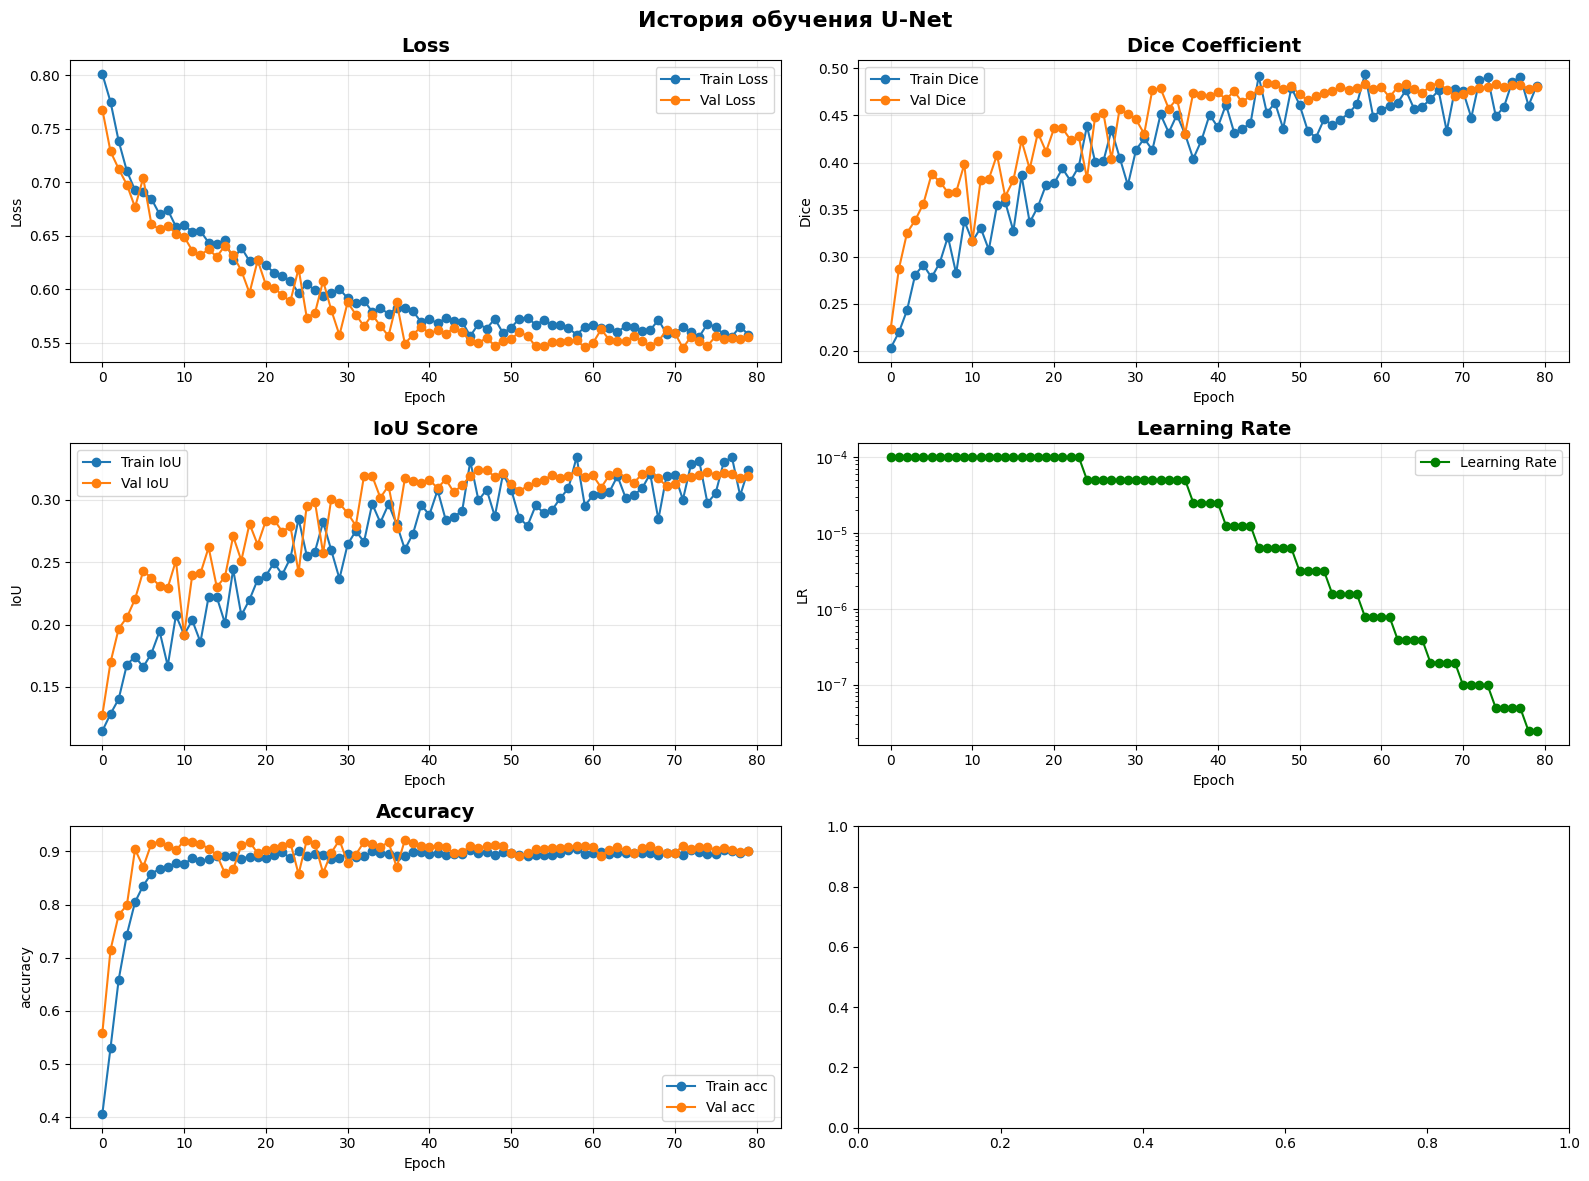

Train Loss: 0.5575
Val Loss: 0.5553
Train Dice: 0.4815
Val Dice: 0.4801
Train IoU: 0.3241
Val IoU: 0.3191
Val Accuracy: 0.9012


In [23]:
def plot_training_history(history):

    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='o')
    axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Dice Coefficient
    axes[0, 1].plot(history['train_dice'], label='Train Dice', marker='o')
    axes[0, 1].plot(history['val_dice'], label='Val Dice', marker='o')
    axes[0, 1].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # IoU Score
    axes[1, 0].plot(history['train_iou'], label='Train IoU', marker='o')
    axes[1, 0].plot(history['val_iou'], label='Val IoU', marker='o')
    axes[1, 0].set_title('IoU Score', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('IoU')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 1].plot(history['lr'], label='Learning Rate', marker='o', color='green')
    axes[1, 1].set_title('Learning Rate', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('LR')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Accuracy
    axes[2, 0].plot(history['train_acc'], label='Train acc', marker='o')
    axes[2, 0].plot(history['val_acc'], label='Val acc', marker='o')
    axes[2, 0].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[2, 0].set_xlabel('Epoch')
    axes[2, 0].set_ylabel('accuracy')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)

    plt.suptitle('История обучения U-Net', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    

    print(f"Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"Train Dice: {history['train_dice'][-1]:.4f}")
    print(f"Val Dice: {history['val_dice'][-1]:.4f}")
    print(f"Train IoU: {history['train_iou'][-1]:.4f}")
    print(f"Val IoU: {history['val_iou'][-1]:.4f}")
    print(f"Val Accuracy: {history['val_acc'][-1]:.4f}")

plot_training_history(history)

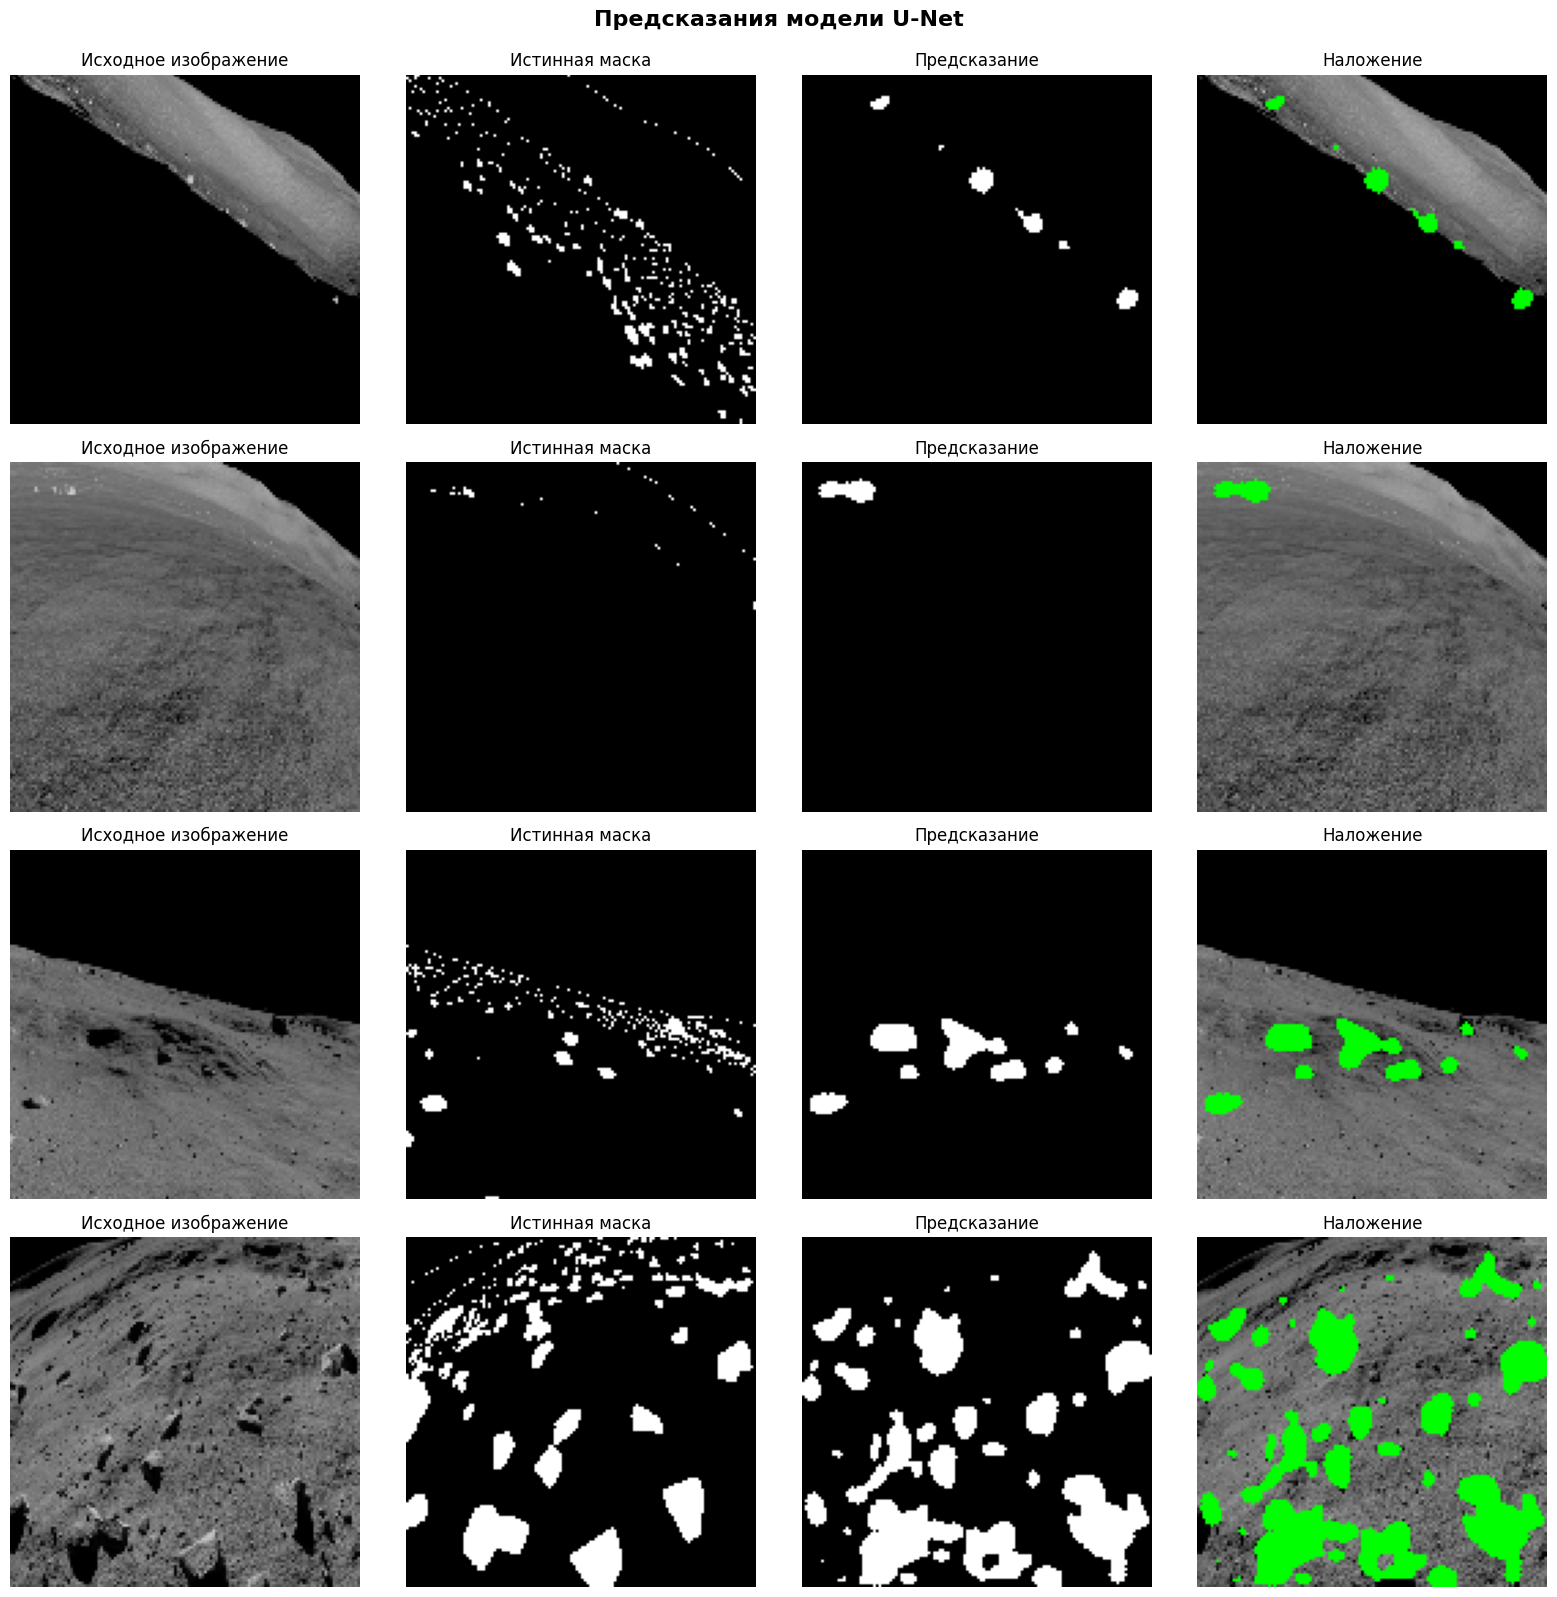

In [24]:
def visualize_predictions(model, dataloader, device, num_samples=4):

    model.eval()
    
    images, masks = next(iter(dataloader))
    images = images.to(device)
    masks = masks.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        predictions = torch.sigmoid(outputs)
        predictions = (predictions > 0.5).float()
    
    images = images.cpu()
    masks = masks.cpu()
    predictions = predictions.cpu()
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    for i in range(min(num_samples, len(images))):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        mask_true = masks[i, :,:].numpy()
        mask_pred = predictions[i, 0].numpy()
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Исходное изображение', fontsize=12)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_true, cmap='gray')
        axes[i, 1].set_title('Истинная маска', fontsize=12)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(mask_pred, cmap='gray')
        axes[i, 2].set_title('Предсказание', fontsize=12)
        axes[i, 2].axis('off')
        
        overlay = img.copy()
        overlay[mask_pred > 0.5] = [0, 1, 0]
        
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Наложение', fontsize=12)
        axes[i, 3].axis('off')
        
        dice = dice_coefficient(outputs[i:i+1], masks[i:i+1])
        iou = iou_score(outputs[i:i+1], masks[i:i+1])
        
        # fig.text(0.5, 1 - (i + 0.5) / num_samples, 
        #         f'Dice: {dice:.4f} | IoU: {iou:.4f}',
        #         ha='center', fontsize=10, fontweight='bold')
    
    plt.suptitle('Предсказания модели U-Net', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_loader, device, num_samples=4)

## Загрузка и тестирование лучшей модели

Параметров: 7,765,985
Уровней encoder: 4
Конфигурация каналов: [32, 64, 128, 256]
Эпоха: 68
Val Dice: 0.4844
Val IoU: 0.3237


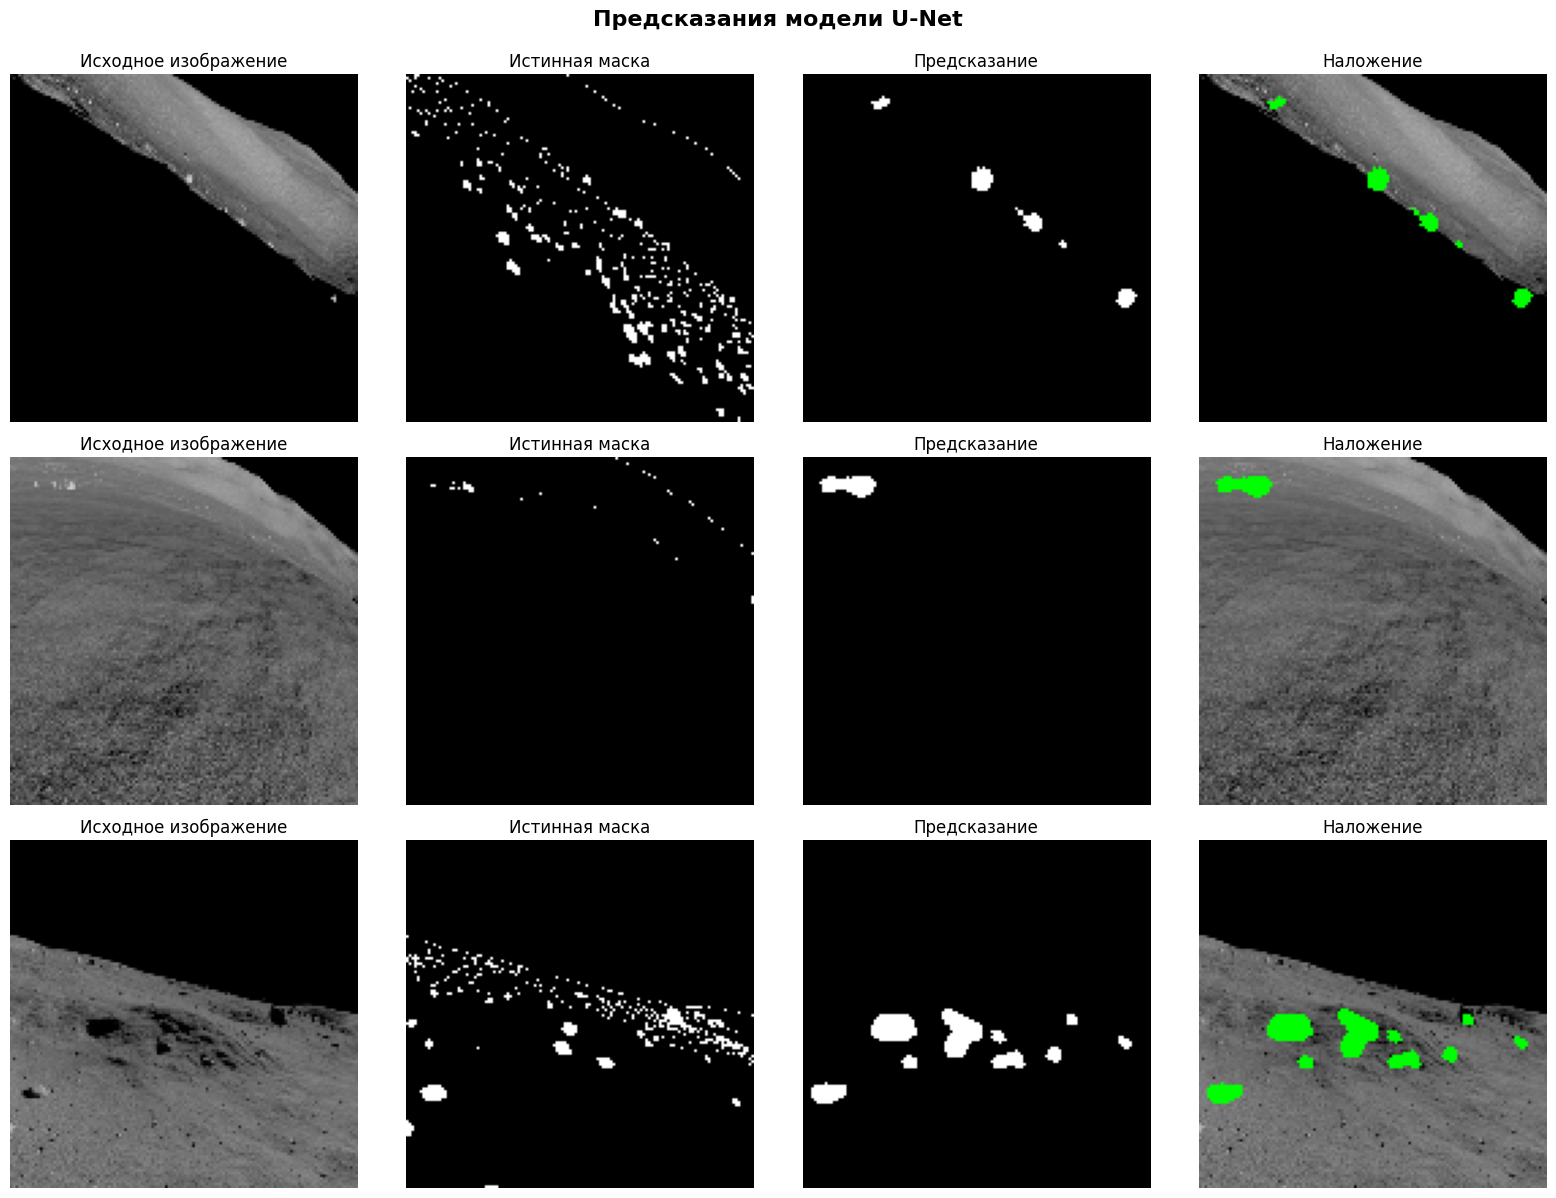

In [25]:
best_model = UNet(in_channels=3, out_channels=1, features=[32, 64, 128, 256])

checkpoint = torch.load('best_moon_unet.pth', map_location=device)
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model = best_model.to(device)

print(f"Эпоха: {checkpoint['epoch'] + 1}")
print(f"Val Dice: {checkpoint['val_dice']:.4f}")
print(f"Val IoU: {checkpoint['val_iou']:.4f}")

visualize_predictions(best_model, val_loader, device, num_samples=3)

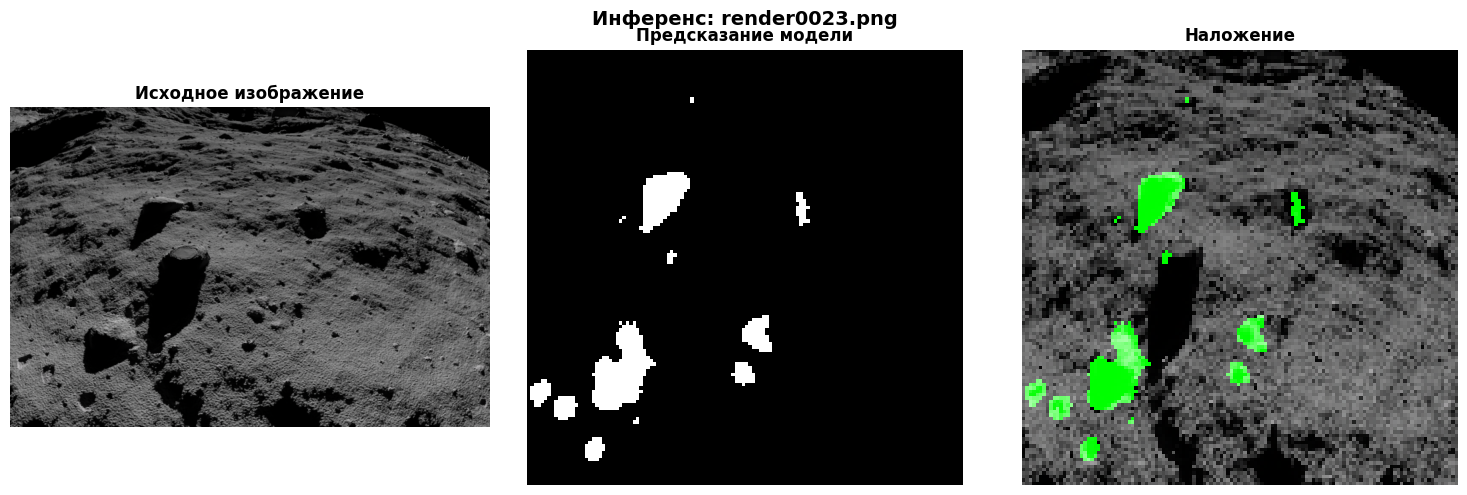

In [26]:
def predict_image(model, image_path, device, threshold=0.5):

    model.eval()
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy()
    
    augmented = val_augmentation(image=image)
    image = augmented['image']
    preprocessed = preprocessing(image=image)
    image_tensor = preprocessed['image'].unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.sigmoid(output)
        prediction = (prediction > threshold).float()
    
    prediction = prediction.cpu().squeeze().numpy()
    
    return prediction, original_image


def visualize_single_prediction(image_path, prediction, original_image):

    overlay = cv2.resize(original_image, (prediction.shape[1], prediction.shape[0]))
    overlay = overlay.astype(float) / 255.0
    overlay[:, :, 1] = np.where(prediction > 0.5, 1, overlay[:, :, 1])
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original_image)
    axes[0].set_title('Исходное изображение', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(prediction, cmap='gray')
    axes[1].set_title('Предсказание модели', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(overlay)
    axes[2].set_title('Наложение', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    plt.suptitle(f'Инференс: {os.path.basename(image_path)}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


random_image_id = np.random.choice(val_ids)
image_path = os.path.join(DATA_ROOT, 'images', 'render', f'{random_image_id}.png')

prediction, original_image = predict_image(best_model, image_path, device)
visualize_single_prediction(image_path, prediction, original_image)


# Часть 3. U-Net с бэкбоном из классификатора

In [27]:
class MyUNet(nn.Module):

    def __init__(self, out_channels=1, freeze_all=False):
        super(MyUNet, self).__init__()

        model_classifier = SimpleModifyNet(num_classes)

        checkpoint = torch.load('best_model_classifier.pth', map_location=device)
        model_classifier.load_state_dict(checkpoint['model_state_dict'])        
        
        # Извлекаем слои энкодера
        self.enc0 = nn.Sequential(
            model_classifier.conv1,    
            model_classifier.bn1,
            model_classifier.relu,
            model_classifier.maxpool
        ) # [B, 64, H/4, W/4] при H=W=128 → [B, 64, 32, 32]
        self.enc1 = nn.Sequential(
            model_classifier.basic_block_1_0,
            model_classifier.basic_block_1_1
        )  # [B, 64, 32, 32]
        self.enc2 = nn.Sequential(
            model_classifier.basic_block_2_0,
            model_classifier.basic_block_2_1
        )  # [B, 128, 16, 16]

        self.enc3 = nn.Sequential(
            model_classifier.bottle_neck_block_3_0,
            model_classifier.bottle_neck_block_3_1
        )  # [B, 256, 8, 8]

        self.enc4 = nn.Sequential(
            model_classifier.bottle_neck_block_4_0,
            model_classifier.bottle_neck_block_4_1
        )  # [B, 512, 4, 4]

        encoders = [self.enc0, self.enc1, self.enc2, self.enc3, self.enc4]
        if freeze_all:
            for enc in encoders:
                for param in enc.parameters():
                    param.requires_grad = False
        else:
            pass  

        # Декодер
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(256 + 256, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(128 + 128, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(64 + 64, 64)

        self.up1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(64 + 64, 64)

        self.final_up = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Энкодер
        x0 = self.enc0(x)      # [B, 64, 32, 32]
        x1 = self.enc1(x0)     # [B, 64, 32, 32]
        x2 = self.enc2(x1)     # [B, 128, 16, 16]
        x3 = self.enc3(x2)     # [B, 256, 8, 8]
        x4 = self.enc4(x3)     # [B, 512, 4, 4]

        # Декодер
        d4 = self.up4(x4)                     # [B, 256, 8, 8]
        d4 = torch.cat([d4, x3], dim=1)
        d4 = self.dec4(d4)                    # [B, 256, 8, 8]

        d3 = self.up3(d4)                     # [B, 128, 16, 16]
        d3 = torch.cat([d3, x2], dim=1)
        d3 = self.dec3(d3)                    # [B, 128, 16, 16]

        d2 = self.up2(d3)                     # [B, 64, 32, 32]
        d2 = torch.cat([d2, x1], dim=1)
        d2 = self.dec2(d2)                    # [B, 64, 32, 32]

        d1 = self.up1(d2)                     # [B, 64, 64, 64]

        x0_adapted = F.interpolate(x0, size=d1.shape[2:], mode='bilinear', align_corners=False)
        d1 = torch.cat([d1, x0_adapted], dim=1)  # [B, 128, 64, 64]
        d1 = self.dec1(d1)                    # [B, 64, 64, 64]

        final = self.final_up(d1)             # [B, 32, 128, 128]
        out = self.out_conv(final)            # [B, 1, 128, 128]
        return out

my_unet = MyUNet(out_channels=1)

test_input = torch.randn(8, 3, 128, 128)
test_output = my_unet(test_input)

print(f"Вход:  {test_input.shape}")
print(f"Выход: {test_output.shape}")

total_params = sum(p.numel() for p in my_unet.parameters())
trainable_params = sum(p.numel() for p in my_unet.parameters() if p.requires_grad)

print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")

Вход:  torch.Size([8, 3, 128, 128])
Выход: torch.Size([8, 1, 128, 128])
Всего параметров: 4,650,241
Обучаемых параметров: 4,650,241


## Вариант А: заморозить веса энкодера, обучать только декодер.

In [28]:
my_unet_freeze = MyUNet(out_channels=1, freeze_all=True)

my_unet_criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)

encoder_params = []
decoder_params = []

encoder_modules = {
    'enc_start', 'enc1', 'enc2', 'enc3', 'enc4'
}

for name, param in my_unet_freeze.named_parameters():
    if any(module in name for module in encoder_modules):
        encoder_params.append(param)
    else:
        decoder_params.append(param)

my_unet_optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr': 1e-4},  # Меньший LR для предобученных слоев
    {'params': decoder_params, 'lr': 1e-3}   # Обычный LR для новых слоев
])

my_unet_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    my_unet_optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5, 
)

NUM_EPOCHS_MY_UNET = 80
SAVE_PATH_MY_UNET_FREEZE = 'best_my_unet_freeze.pth'

print(f"Эпох: {NUM_EPOCHS_MY_UNET}")
print(f"Encoder LR: 1e-4 (fine-tuning)")
print(f"Decoder LR: 1e-3")
print(f"Модель будет сохранена в: {SAVE_PATH_MY_UNET_FREEZE}")


Эпох: 80
Encoder LR: 1e-4 (fine-tuning)
Decoder LR: 1e-3
Модель будет сохранена в: best_my_unet_freeze.pth


In [29]:
my_unet_freeze_history = train_model(
    model=my_unet_freeze,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=my_unet_criterion,
    optimizer=my_unet_optimizer,
    scheduler=my_unet_scheduler,
    num_epochs=NUM_EPOCHS_MY_UNET,
    device=device,
    save_path=SAVE_PATH_MY_UNET_FREEZE
)


Эпоха 1/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.10it/s, loss=0.5601, dice=0.0026, iou=0.0013, acc=0.8964]



 Результаты эпохи 1:
  Train - Loss: 0.6653, Dice: 0.0410, IoU: 0.0223
  Val   - Loss: 0.5932, Dice: 0.0014, IoU: 0.0007, Acc: 0.9156
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.0014
Эпоха 2/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.34it/s, loss=0.4745, dice=0.3109, iou=0.1841, acc=0.8915]



 Результаты эпохи 2:
  Train - Loss: 0.5621, Dice: 0.0618, IoU: 0.0336
  Val   - Loss: 0.4998, Dice: 0.2568, IoU: 0.1491, Acc: 0.9068
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.2568
Эпоха 3/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.16it/s, loss=0.4510, dice=0.4674, iou=0.3049, acc=0.8437]



 Результаты эпохи 3:
  Train - Loss: 0.5247, Dice: 0.2879, IoU: 0.1713
  Val   - Loss: 0.4838, Dice: 0.3880, IoU: 0.2437, Acc: 0.8464
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3880
Эпоха 4/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.41it/s, loss=0.4600, dice=0.4884, iou=0.3231, acc=0.8689]



 Результаты эпохи 4:
  Train - Loss: 0.5168, Dice: 0.3517, IoU: 0.2197
  Val   - Loss: 0.4903, Dice: 0.4064, IoU: 0.2588, Acc: 0.8784
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4064
Эпоха 5/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.24it/s, loss=0.4839, dice=0.4379, iou=0.2804, acc=0.7824]



 Результаты эпохи 5:
  Train - Loss: 0.4959, Dice: 0.3630, IoU: 0.2245
  Val   - Loss: 0.5248, Dice: 0.3515, IoU: 0.2166, Acc: 0.7839
  LR: 0.000100
Эпоха 6/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.91it/s, loss=0.4142, dice=0.5161, iou=0.3478, acc=0.8999]



 Результаты эпохи 6:
  Train - Loss: 0.5028, Dice: 0.3615, IoU: 0.2258
  Val   - Loss: 0.4438, Dice: 0.4379, IoU: 0.2828, Acc: 0.9057
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4379
Эпоха 7/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.90it/s, loss=0.4293, dice=0.4851, iou=0.3202, acc=0.8580]



 Результаты эпохи 7:
  Train - Loss: 0.4973, Dice: 0.3566, IoU: 0.2239
  Val   - Loss: 0.4795, Dice: 0.3926, IoU: 0.2481, Acc: 0.8488
  LR: 0.000050
Эпоха 8/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.28it/s, loss=0.4208, dice=0.5047, iou=0.3375, acc=0.8764]



 Результаты эпохи 8:
  Train - Loss: 0.5053, Dice: 0.3373, IoU: 0.2103
  Val   - Loss: 0.4714, Dice: 0.4061, IoU: 0.2588, Acc: 0.8665
  LR: 0.000050
Эпоха 9/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.40it/s, loss=0.4132, dice=0.5169, iou=0.3485, acc=0.8898]



 Результаты эпохи 9:
  Train - Loss: 0.5085, Dice: 0.3402, IoU: 0.2109
  Val   - Loss: 0.4604, Dice: 0.4218, IoU: 0.2709, Acc: 0.8807
  LR: 0.000050
Эпоха 10/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.65it/s, loss=0.4082, dice=0.5236, iou=0.3547, acc=0.8822]



 Результаты эпохи 10:
  Train - Loss: 0.4928, Dice: 0.3527, IoU: 0.2200
  Val   - Loss: 0.4553, Dice: 0.4334, IoU: 0.2807, Acc: 0.8801
  LR: 0.000050
Эпоха 11/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.03it/s, loss=0.4194, dice=0.4948, iou=0.3287, acc=0.8662]



 Результаты эпохи 11:
  Train - Loss: 0.4806, Dice: 0.3783, IoU: 0.2358
  Val   - Loss: 0.4706, Dice: 0.4036, IoU: 0.2573, Acc: 0.8568
  LR: 0.000050
Эпоха 12/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.26it/s, loss=0.4121, dice=0.5151, iou=0.3469, acc=0.8865]



 Результаты эпохи 12:
  Train - Loss: 0.4620, Dice: 0.4246, IoU: 0.2728
  Val   - Loss: 0.4621, Dice: 0.4135, IoU: 0.2652, Acc: 0.8725
  LR: 0.000050
Эпоха 13/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.63it/s, loss=0.3998, dice=0.5213, iou=0.3525, acc=0.8942]



 Результаты эпохи 13:
  Train - Loss: 0.4651, Dice: 0.4087, IoU: 0.2599
  Val   - Loss: 0.4413, Dice: 0.4335, IoU: 0.2810, Acc: 0.8893
  LR: 0.000025
Эпоха 14/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.51it/s, loss=0.3955, dice=0.5330, iou=0.3634, acc=0.8944]



 Результаты эпохи 14:
  Train - Loss: 0.4754, Dice: 0.3875, IoU: 0.2464
  Val   - Loss: 0.4431, Dice: 0.4318, IoU: 0.2803, Acc: 0.8875
  LR: 0.000025
Эпоха 15/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.52it/s, loss=0.4043, dice=0.5263, iou=0.3571, acc=0.8881]



 Результаты эпохи 15:
  Train - Loss: 0.4555, Dice: 0.4238, IoU: 0.2759
  Val   - Loss: 0.4515, Dice: 0.4216, IoU: 0.2724, Acc: 0.8810
  LR: 0.000025
Эпоха 16/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.01it/s, loss=0.3997, dice=0.5293, iou=0.3599, acc=0.8904]



 Результаты эпохи 16:
  Train - Loss: 0.4728, Dice: 0.3816, IoU: 0.2442
  Val   - Loss: 0.4480, Dice: 0.4340, IoU: 0.2816, Acc: 0.8815
  LR: 0.000025
Эпоха 17/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.44it/s, loss=0.3924, dice=0.5320, iou=0.3624, acc=0.9065]



 Результаты эпохи 17:
  Train - Loss: 0.4574, Dice: 0.4177, IoU: 0.2692
  Val   - Loss: 0.4246, Dice: 0.4544, IoU: 0.2992, Acc: 0.9042
  LR: 0.000025
  Сохранена лучшая модель! Dice: 0.4544
Эпоха 18/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.78it/s, loss=0.3921, dice=0.5420, iou=0.3717, acc=0.8921]



 Результаты эпохи 18:
  Train - Loss: 0.4807, Dice: 0.3887, IoU: 0.2468
  Val   - Loss: 0.4446, Dice: 0.4390, IoU: 0.2858, Acc: 0.8800
  LR: 0.000025
Эпоха 19/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.41it/s, loss=0.3844, dice=0.5420, iou=0.3717, acc=0.9103]



 Результаты эпохи 19:
  Train - Loss: 0.4830, Dice: 0.3611, IoU: 0.2254
  Val   - Loss: 0.4179, Dice: 0.4640, IoU: 0.3057, Acc: 0.9097
  LR: 0.000013
  Сохранена лучшая модель! Dice: 0.4640
Эпоха 20/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.38it/s, loss=0.3884, dice=0.5371, iou=0.3671, acc=0.8989]



 Результаты эпохи 20:
  Train - Loss: 0.4509, Dice: 0.4334, IoU: 0.2808
  Val   - Loss: 0.4283, Dice: 0.4569, IoU: 0.2996, Acc: 0.8930
  LR: 0.000013
Эпоха 21/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.39it/s, loss=0.3831, dice=0.5483, iou=0.3777, acc=0.8993]



 Результаты эпохи 21:
  Train - Loss: 0.4522, Dice: 0.4283, IoU: 0.2784
  Val   - Loss: 0.4291, Dice: 0.4591, IoU: 0.3020, Acc: 0.8890
  LR: 0.000013
Эпоха 22/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.52it/s, loss=0.3754, dice=0.5610, iou=0.3899, acc=0.9080]



 Результаты эпохи 22:
  Train - Loss: 0.4572, Dice: 0.4134, IoU: 0.2659
  Val   - Loss: 0.4190, Dice: 0.4629, IoU: 0.3057, Acc: 0.9009
  LR: 0.000013
Эпоха 23/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.25it/s, loss=0.3785, dice=0.5510, iou=0.3803, acc=0.9099]



 Результаты эпохи 23:
  Train - Loss: 0.4411, Dice: 0.4548, IoU: 0.2973
  Val   - Loss: 0.4196, Dice: 0.4630, IoU: 0.3063, Acc: 0.9041
  LR: 0.000013
Эпоха 24/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.66it/s, loss=0.3770, dice=0.5548, iou=0.3839, acc=0.9063]



 Результаты эпохи 24:
  Train - Loss: 0.4688, Dice: 0.3950, IoU: 0.2538
  Val   - Loss: 0.4309, Dice: 0.4559, IoU: 0.2995, Acc: 0.8918
  LR: 0.000013
Эпоха 25/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.48it/s, loss=0.3768, dice=0.5544, iou=0.3835, acc=0.9036]



 Результаты эпохи 25:
  Train - Loss: 0.4690, Dice: 0.3896, IoU: 0.2497
  Val   - Loss: 0.4274, Dice: 0.4618, IoU: 0.3039, Acc: 0.8917
  LR: 0.000006
Эпоха 26/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.85it/s, loss=0.3767, dice=0.5552, iou=0.3842, acc=0.9063]



 Результаты эпохи 26:
  Train - Loss: 0.4603, Dice: 0.4063, IoU: 0.2617
  Val   - Loss: 0.4255, Dice: 0.4632, IoU: 0.3052, Acc: 0.8962
  LR: 0.000006
Эпоха 27/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.94it/s, loss=0.3751, dice=0.5573, iou=0.3863, acc=0.9087]



 Результаты эпохи 27:
  Train - Loss: 0.4472, Dice: 0.4221, IoU: 0.2738
  Val   - Loss: 0.4242, Dice: 0.4626, IoU: 0.3052, Acc: 0.9002
  LR: 0.000006
Эпоха 28/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.52it/s, loss=0.3763, dice=0.5557, iou=0.3847, acc=0.9090]



 Результаты эпохи 28:
  Train - Loss: 0.4557, Dice: 0.4259, IoU: 0.2765
  Val   - Loss: 0.4205, Dice: 0.4647, IoU: 0.3069, Acc: 0.9031
  LR: 0.000006
  Сохранена лучшая модель! Dice: 0.4647
Эпоха 29/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.56it/s, loss=0.3782, dice=0.5507, iou=0.3800, acc=0.9104]



 Результаты эпохи 29:
  Train - Loss: 0.4549, Dice: 0.4256, IoU: 0.2751
  Val   - Loss: 0.4167, Dice: 0.4665, IoU: 0.3084, Acc: 0.9066
  LR: 0.000006
  Сохранена лучшая модель! Dice: 0.4665
Эпоха 30/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.57it/s, loss=0.3777, dice=0.5532, iou=0.3823, acc=0.9153]



 Результаты эпохи 30:
  Train - Loss: 0.4565, Dice: 0.4246, IoU: 0.2762
  Val   - Loss: 0.4121, Dice: 0.4741, IoU: 0.3155, Acc: 0.9133
  LR: 0.000006
  Сохранена лучшая модель! Dice: 0.4741
Эпоха 31/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.25it/s, loss=0.3743, dice=0.5558, iou=0.3848, acc=0.9121]



 Результаты эпохи 31:
  Train - Loss: 0.4383, Dice: 0.4412, IoU: 0.2875
  Val   - Loss: 0.4153, Dice: 0.4713, IoU: 0.3126, Acc: 0.9071
  LR: 0.000003
Эпоха 32/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.87it/s, loss=0.3763, dice=0.5554, iou=0.3845, acc=0.9103]



 Результаты эпохи 32:
  Train - Loss: 0.4344, Dice: 0.4511, IoU: 0.2969
  Val   - Loss: 0.4207, Dice: 0.4636, IoU: 0.3060, Acc: 0.9016
  LR: 0.000003
Эпоха 33/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.11it/s, loss=0.3772, dice=0.5516, iou=0.3808, acc=0.9058]



 Результаты эпохи 33:
  Train - Loss: 0.4489, Dice: 0.4280, IoU: 0.2759
  Val   - Loss: 0.4220, Dice: 0.4594, IoU: 0.3025, Acc: 0.8975
  LR: 0.000003
Эпоха 34/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.82it/s, loss=0.3719, dice=0.5604, iou=0.3893, acc=0.9113]



 Результаты эпохи 34:
  Train - Loss: 0.4623, Dice: 0.3969, IoU: 0.2543
  Val   - Loss: 0.4163, Dice: 0.4696, IoU: 0.3111, Acc: 0.9040
  LR: 0.000003
Эпоха 35/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.94it/s, loss=0.3769, dice=0.5465, iou=0.3760, acc=0.9162]



 Результаты эпохи 35:
  Train - Loss: 0.4602, Dice: 0.4066, IoU: 0.2596
  Val   - Loss: 0.4151, Dice: 0.4610, IoU: 0.3038, Acc: 0.9139
  LR: 0.000003
Эпоха 36/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.05it/s, loss=0.3769, dice=0.5555, iou=0.3845, acc=0.9009]



 Результаты эпохи 36:
  Train - Loss: 0.4736, Dice: 0.3804, IoU: 0.2407
  Val   - Loss: 0.4318, Dice: 0.4539, IoU: 0.2979, Acc: 0.8871
  LR: 0.000003
Эпоха 37/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.25it/s, loss=0.3724, dice=0.5573, iou=0.3863, acc=0.9134]



 Результаты эпохи 37:
  Train - Loss: 0.4633, Dice: 0.3923, IoU: 0.2499
  Val   - Loss: 0.4125, Dice: 0.4760, IoU: 0.3165, Acc: 0.9089
  LR: 0.000002
  Сохранена лучшая модель! Dice: 0.4760
Эпоха 38/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.32it/s, loss=0.3752, dice=0.5549, iou=0.3840, acc=0.9070]



 Результаты эпохи 38:
  Train - Loss: 0.4467, Dice: 0.4270, IoU: 0.2798
  Val   - Loss: 0.4213, Dice: 0.4668, IoU: 0.3083, Acc: 0.8983
  LR: 0.000002
Эпоха 39/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.90it/s, loss=0.3753, dice=0.5572, iou=0.3862, acc=0.9102]



 Результаты эпохи 39:
  Train - Loss: 0.4657, Dice: 0.4022, IoU: 0.2553
  Val   - Loss: 0.4194, Dice: 0.4643, IoU: 0.3065, Acc: 0.9017
  LR: 0.000002
Эпоха 40/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.70it/s, loss=0.3772, dice=0.5554, iou=0.3845, acc=0.9060]



 Результаты эпохи 40:
  Train - Loss: 0.4372, Dice: 0.4478, IoU: 0.2954
  Val   - Loss: 0.4244, Dice: 0.4597, IoU: 0.3027, Acc: 0.8956
  LR: 0.000002
Эпоха 41/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.42it/s, loss=0.3759, dice=0.5553, iou=0.3844, acc=0.9071]



 Результаты эпохи 41:
  Train - Loss: 0.4592, Dice: 0.4024, IoU: 0.2600
  Val   - Loss: 0.4229, Dice: 0.4627, IoU: 0.3053, Acc: 0.8961
  LR: 0.000002
Эпоха 42/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.67it/s, loss=0.3773, dice=0.5517, iou=0.3810, acc=0.9090]



 Результаты эпохи 42:
  Train - Loss: 0.4566, Dice: 0.4042, IoU: 0.2595
  Val   - Loss: 0.4185, Dice: 0.4656, IoU: 0.3076, Acc: 0.9022
  LR: 0.000002
Эпоха 43/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.51it/s, loss=0.3757, dice=0.5516, iou=0.3809, acc=0.9126]



 Результаты эпохи 43:
  Train - Loss: 0.4478, Dice: 0.4329, IoU: 0.2829
  Val   - Loss: 0.4149, Dice: 0.4715, IoU: 0.3127, Acc: 0.9078
  LR: 0.000001
Эпоха 44/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.13it/s, loss=0.3779, dice=0.5515, iou=0.3807, acc=0.9062]



 Результаты эпохи 44:
  Train - Loss: 0.4416, Dice: 0.4439, IoU: 0.2922
  Val   - Loss: 0.4242, Dice: 0.4583, IoU: 0.3016, Acc: 0.8965
  LR: 0.000001
Эпоха 45/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.30it/s, loss=0.3753, dice=0.5522, iou=0.3814, acc=0.9077]



 Результаты эпохи 45:
  Train - Loss: 0.4495, Dice: 0.4315, IoU: 0.2817
  Val   - Loss: 0.4193, Dice: 0.4665, IoU: 0.3083, Acc: 0.9000
  LR: 0.000001
Эпоха 46/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.88it/s, loss=0.3765, dice=0.5532, iou=0.3824, acc=0.9100]



 Результаты эпохи 46:
  Train - Loss: 0.4483, Dice: 0.4274, IoU: 0.2784
  Val   - Loss: 0.4168, Dice: 0.4711, IoU: 0.3125, Acc: 0.9038
  LR: 0.000001
Эпоха 47/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.80it/s, loss=0.3776, dice=0.5520, iou=0.3812, acc=0.9119]



 Результаты эпохи 47:
  Train - Loss: 0.4552, Dice: 0.4278, IoU: 0.2781
  Val   - Loss: 0.4144, Dice: 0.4714, IoU: 0.3127, Acc: 0.9066
  LR: 0.000001
Эпоха 48/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.30it/s, loss=0.3796, dice=0.5515, iou=0.3807, acc=0.9033]



 Результаты эпохи 48:
  Train - Loss: 0.4308, Dice: 0.4605, IoU: 0.3027
  Val   - Loss: 0.4296, Dice: 0.4528, IoU: 0.2971, Acc: 0.8906
  LR: 0.000001
Эпоха 49/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.99it/s, loss=0.3761, dice=0.5582, iou=0.3871, acc=0.9091]



 Результаты эпохи 49:
  Train - Loss: 0.4597, Dice: 0.4160, IoU: 0.2707
  Val   - Loss: 0.4265, Dice: 0.4602, IoU: 0.3032, Acc: 0.8971
  LR: 0.000000
Эпоха 50/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.24it/s, loss=0.3779, dice=0.5503, iou=0.3796, acc=0.9139]



 Результаты эпохи 50:
  Train - Loss: 0.4417, Dice: 0.4413, IoU: 0.2895
  Val   - Loss: 0.4144, Dice: 0.4711, IoU: 0.3127, Acc: 0.9101
  LR: 0.000000
Эпоха 51/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.51it/s, loss=0.3748, dice=0.5559, iou=0.3849, acc=0.9121]



 Результаты эпохи 51:
  Train - Loss: 0.4440, Dice: 0.4324, IoU: 0.2803
  Val   - Loss: 0.4189, Dice: 0.4653, IoU: 0.3074, Acc: 0.9047
  LR: 0.000000
Эпоха 52/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.77it/s, loss=0.3760, dice=0.5529, iou=0.3821, acc=0.9118]



 Результаты эпохи 52:
  Train - Loss: 0.4611, Dice: 0.4134, IoU: 0.2658
  Val   - Loss: 0.4152, Dice: 0.4708, IoU: 0.3122, Acc: 0.9059
  LR: 0.000000
Эпоха 53/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.93it/s, loss=0.3766, dice=0.5504, iou=0.3797, acc=0.9085]



 Результаты эпохи 53:
  Train - Loss: 0.4682, Dice: 0.4067, IoU: 0.2609
  Val   - Loss: 0.4218, Dice: 0.4608, IoU: 0.3035, Acc: 0.8997
  LR: 0.000000
Эпоха 54/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.89it/s, loss=0.3768, dice=0.5514, iou=0.3806, acc=0.9121]



 Результаты эпохи 54:
  Train - Loss: 0.4526, Dice: 0.4139, IoU: 0.2657
  Val   - Loss: 0.4176, Dice: 0.4650, IoU: 0.3074, Acc: 0.9062
  LR: 0.000000
Эпоха 55/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.43it/s, loss=0.3749, dice=0.5552, iou=0.3843, acc=0.9077]



 Результаты эпохи 55:
  Train - Loss: 0.4430, Dice: 0.4337, IoU: 0.2832
  Val   - Loss: 0.4213, Dice: 0.4641, IoU: 0.3063, Acc: 0.8988
  LR: 0.000000
Эпоха 56/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.94it/s, loss=0.3752, dice=0.5546, iou=0.3837, acc=0.9120]



 Результаты эпохи 56:
  Train - Loss: 0.4459, Dice: 0.4336, IoU: 0.2818
  Val   - Loss: 0.4192, Dice: 0.4653, IoU: 0.3076, Acc: 0.9048
  LR: 0.000000
Эпоха 57/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.83it/s, loss=0.3773, dice=0.5508, iou=0.3801, acc=0.9087]



 Результаты эпохи 57:
  Train - Loss: 0.4543, Dice: 0.4091, IoU: 0.2650
  Val   - Loss: 0.4232, Dice: 0.4553, IoU: 0.2994, Acc: 0.8993
  LR: 0.000000
Эпоха 58/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.68it/s, loss=0.3772, dice=0.5548, iou=0.3839, acc=0.9058]



 Результаты эпохи 58:
  Train - Loss: 0.4425, Dice: 0.4330, IoU: 0.2845
  Val   - Loss: 0.4269, Dice: 0.4594, IoU: 0.3025, Acc: 0.8950
  LR: 0.000000
Эпоха 59/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.23it/s, loss=0.3757, dice=0.5539, iou=0.3831, acc=0.9059]



 Результаты эпохи 59:
  Train - Loss: 0.4581, Dice: 0.4099, IoU: 0.2648
  Val   - Loss: 0.4240, Dice: 0.4607, IoU: 0.3034, Acc: 0.8963
  LR: 0.000000
Эпоха 60/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.14it/s, loss=0.3773, dice=0.5496, iou=0.3789, acc=0.9134]



 Результаты эпохи 60:
  Train - Loss: 0.4398, Dice: 0.4448, IoU: 0.2897
  Val   - Loss: 0.4173, Dice: 0.4609, IoU: 0.3039, Acc: 0.9076
  LR: 0.000000
Эпоха 61/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.16it/s, loss=0.3785, dice=0.5504, iou=0.3797, acc=0.9096]



 Результаты эпохи 61:
  Train - Loss: 0.4534, Dice: 0.4275, IoU: 0.2780
  Val   - Loss: 0.4214, Dice: 0.4583, IoU: 0.3017, Acc: 0.9023
  LR: 0.000000
Эпоха 62/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.62it/s, loss=0.3776, dice=0.5500, iou=0.3793, acc=0.9102]



 Результаты эпохи 62:
  Train - Loss: 0.4582, Dice: 0.4054, IoU: 0.2603
  Val   - Loss: 0.4191, Dice: 0.4634, IoU: 0.3060, Acc: 0.9031
  LR: 0.000000
Эпоха 63/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.66it/s, loss=0.3797, dice=0.5491, iou=0.3785, acc=0.9024]



 Результаты эпохи 63:
  Train - Loss: 0.4397, Dice: 0.4455, IoU: 0.2917
  Val   - Loss: 0.4317, Dice: 0.4508, IoU: 0.2955, Acc: 0.8895
  LR: 0.000000
Эпоха 64/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.28it/s, loss=0.3773, dice=0.5517, iou=0.3809, acc=0.9051]



 Результаты эпохи 64:
  Train - Loss: 0.4378, Dice: 0.4452, IoU: 0.2903
  Val   - Loss: 0.4259, Dice: 0.4570, IoU: 0.3008, Acc: 0.8939
  LR: 0.000000
Эпоха 65/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.50it/s, loss=0.3738, dice=0.5578, iou=0.3868, acc=0.9100]



 Результаты эпохи 65:
  Train - Loss: 0.4528, Dice: 0.4207, IoU: 0.2717
  Val   - Loss: 0.4184, Dice: 0.4694, IoU: 0.3107, Acc: 0.9024
  LR: 0.000000
Эпоха 66/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.91it/s, loss=0.3764, dice=0.5519, iou=0.3812, acc=0.9093]



 Результаты эпохи 66:
  Train - Loss: 0.4368, Dice: 0.4491, IoU: 0.2935
  Val   - Loss: 0.4192, Dice: 0.4649, IoU: 0.3069, Acc: 0.9018
  LR: 0.000000
Эпоха 67/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.32it/s, loss=0.3749, dice=0.5539, iou=0.3830, acc=0.9075]



 Результаты эпохи 67:
  Train - Loss: 0.4469, Dice: 0.4290, IoU: 0.2786
  Val   - Loss: 0.4220, Dice: 0.4629, IoU: 0.3052, Acc: 0.8988
  LR: 0.000000
Эпоха 68/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.48it/s, loss=0.3750, dice=0.5512, iou=0.3804, acc=0.9123]



 Результаты эпохи 68:
  Train - Loss: 0.4438, Dice: 0.4348, IoU: 0.2855
  Val   - Loss: 0.4141, Dice: 0.4699, IoU: 0.3114, Acc: 0.9074
  LR: 0.000000
Эпоха 69/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.05it/s, loss=0.3751, dice=0.5515, iou=0.3807, acc=0.9118]



 Результаты эпохи 69:
  Train - Loss: 0.4593, Dice: 0.4066, IoU: 0.2631
  Val   - Loss: 0.4144, Dice: 0.4713, IoU: 0.3127, Acc: 0.9076
  LR: 0.000000
Эпоха 70/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.23it/s, loss=0.3750, dice=0.5550, iou=0.3841, acc=0.9103]



 Результаты эпохи 70:
  Train - Loss: 0.4470, Dice: 0.4366, IoU: 0.2835
  Val   - Loss: 0.4191, Dice: 0.4648, IoU: 0.3069, Acc: 0.9031
  LR: 0.000000
Эпоха 71/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.38it/s, loss=0.3781, dice=0.5517, iou=0.3810, acc=0.9108]



 Результаты эпохи 71:
  Train - Loss: 0.4511, Dice: 0.4197, IoU: 0.2715
  Val   - Loss: 0.4222, Dice: 0.4565, IoU: 0.3005, Acc: 0.9025
  LR: 0.000000
Эпоха 72/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.79it/s, loss=0.3755, dice=0.5542, iou=0.3834, acc=0.9073]



 Результаты эпохи 72:
  Train - Loss: 0.4465, Dice: 0.4350, IoU: 0.2855
  Val   - Loss: 0.4217, Dice: 0.4635, IoU: 0.3059, Acc: 0.8981
  LR: 0.000000
Эпоха 73/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.15it/s, loss=0.3757, dice=0.5543, iou=0.3834, acc=0.9071]



 Результаты эпохи 73:
  Train - Loss: 0.4533, Dice: 0.4100, IoU: 0.2640
  Val   - Loss: 0.4213, Dice: 0.4656, IoU: 0.3075, Acc: 0.8993
  LR: 0.000000
Эпоха 74/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.25it/s, loss=0.3762, dice=0.5564, iou=0.3854, acc=0.9070]



 Результаты эпохи 74:
  Train - Loss: 0.4420, Dice: 0.4351, IoU: 0.2833
  Val   - Loss: 0.4257, Dice: 0.4601, IoU: 0.3031, Acc: 0.8960
  LR: 0.000000
Эпоха 75/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.25it/s, loss=0.3807, dice=0.5483, iou=0.3777, acc=0.9043]



 Результаты эпохи 75:
  Train - Loss: 0.4299, Dice: 0.4599, IoU: 0.3035
  Val   - Loss: 0.4292, Dice: 0.4493, IoU: 0.2945, Acc: 0.8929
  LR: 0.000000
Эпоха 76/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.59it/s, loss=0.3743, dice=0.5505, iou=0.3798, acc=0.9125]



 Результаты эпохи 76:
  Train - Loss: 0.4656, Dice: 0.3920, IoU: 0.2488
  Val   - Loss: 0.4131, Dice: 0.4723, IoU: 0.3136, Acc: 0.9085
  LR: 0.000000
Эпоха 77/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.29it/s, loss=0.3757, dice=0.5560, iou=0.3851, acc=0.9038]



 Результаты эпохи 77:
  Train - Loss: 0.4399, Dice: 0.4403, IoU: 0.2872
  Val   - Loss: 0.4274, Dice: 0.4598, IoU: 0.3026, Acc: 0.8925
  LR: 0.000000
Эпоха 78/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.82it/s, loss=0.3777, dice=0.5487, iou=0.3781, acc=0.9142]



 Результаты эпохи 78:
  Train - Loss: 0.4302, Dice: 0.4640, IoU: 0.3046
  Val   - Loss: 0.4126, Dice: 0.4711, IoU: 0.3127, Acc: 0.9113
  LR: 0.000000
Эпоха 79/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.45it/s, loss=0.3769, dice=0.5492, iou=0.3785, acc=0.9146]



 Результаты эпохи 79:
  Train - Loss: 0.4755, Dice: 0.3829, IoU: 0.2446
  Val   - Loss: 0.4120, Dice: 0.4704, IoU: 0.3120, Acc: 0.9122
  LR: 0.000000
Эпоха 80/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.44it/s, loss=0.3740, dice=0.5538, iou=0.3830, acc=0.9108]


 Результаты эпохи 80:
  Train - Loss: 0.4461, Dice: 0.4346, IoU: 0.2839
  Val   - Loss: 0.4164, Dice: 0.4684, IoU: 0.3100, Acc: 0.9041
  LR: 0.000000
Лучший Val Dice: 0.4760


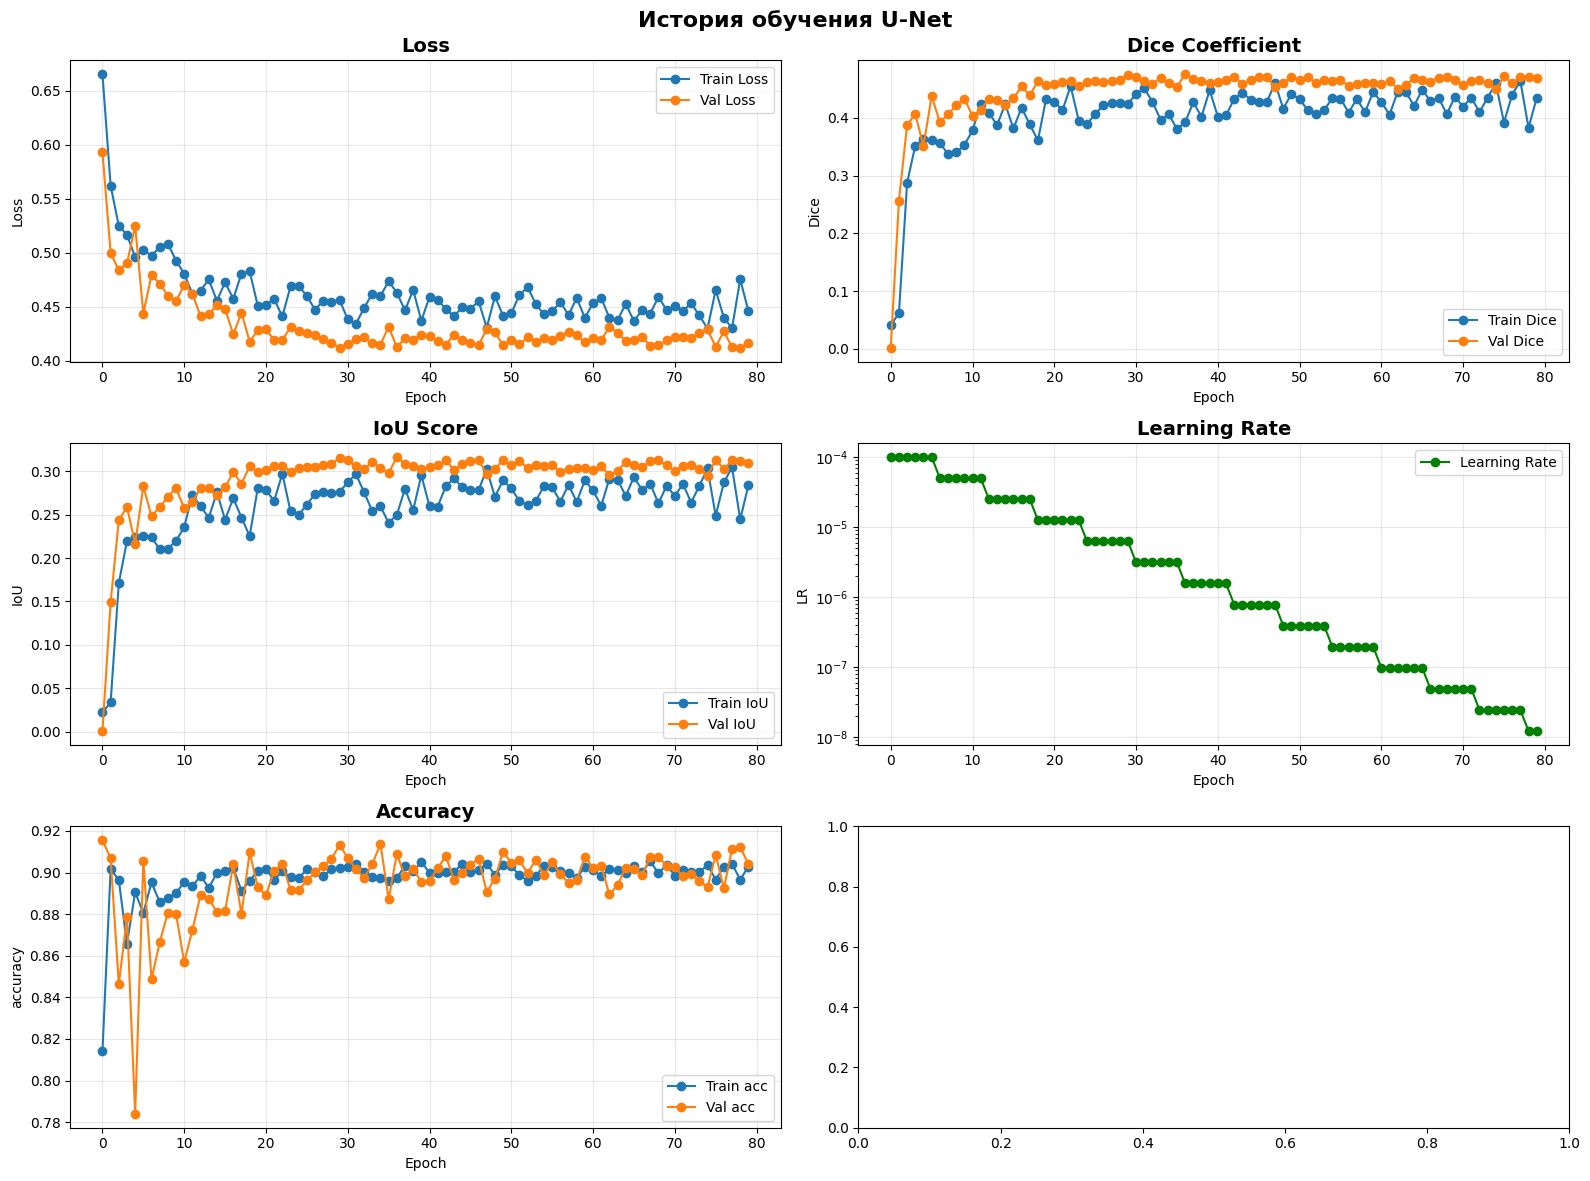

Train Loss: 0.4461
Val Loss: 0.4164
Train Dice: 0.4346
Val Dice: 0.4684
Train IoU: 0.2839
Val IoU: 0.3100
Val Accuracy: 0.9041


In [30]:
plot_training_history(my_unet_freeze_history)

c:\Users\User\anaconda3\envs\neural_networks\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


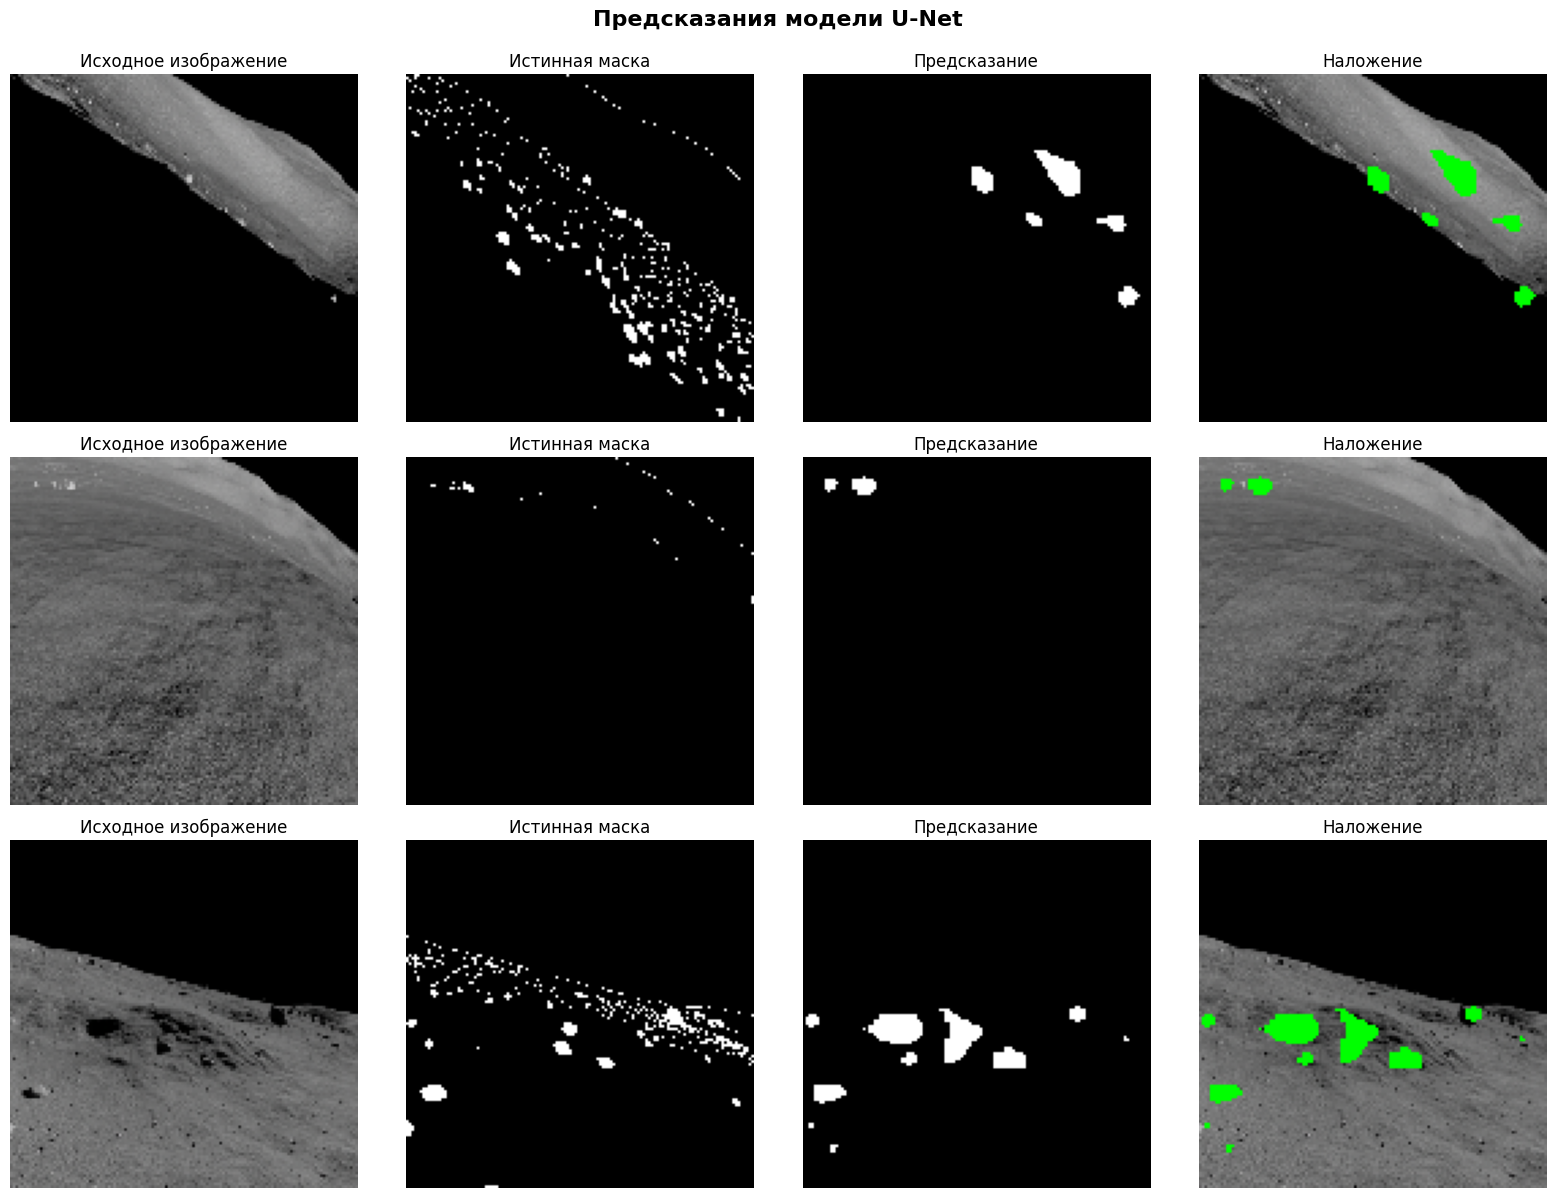

In [31]:
visualize_predictions(my_unet_freeze, val_loader, device, num_samples=3)

## Вариант B: полностью разморозить энкодер на поздних этапах.

In [32]:
my_unet_without_freeze = MyUNet(out_channels=1, freeze_all=False)

# Разделяем параметры на encoder (model_classifier) и decoder
encoder_params = []
decoder_params = []

encoder_modules = {
    'enc_start', 'enc1', 'enc2', 'enc3', 'enc4'
}

for name, param in my_unet_without_freeze.named_parameters():
    if any(module in name for module in encoder_modules):
        encoder_params.append(param)
    else:
        decoder_params.append(param)

my_unet_without_freeze_criterion =  CombinedLoss(bce_weight=0.5, dice_weight=0.5)

my_unet_without_freeze_optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr': 1e-4},
    {'params': decoder_params, 'lr': 1e-3}
])

my_unet_without_freeze_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    my_unet_without_freeze_optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5, 
)

SAVE_PATH_MY_UNET_WITHOUT_FREEZE = 'best_my_unet_without_freeze.pth'

print(f"Эпох: {NUM_EPOCHS_MY_UNET}")
print(f"Encoder LR: 1e-4 (fine-tuning)")
print(f"Decoder LR: 1e-3")
print(f"Модель будет сохранена в: {SAVE_PATH_MY_UNET_WITHOUT_FREEZE}")

Эпох: 80
Encoder LR: 1e-4 (fine-tuning)
Decoder LR: 1e-3
Модель будет сохранена в: best_my_unet_without_freeze.pth


In [33]:
my_unet_without_freeze_history = train_model(
    model=my_unet_without_freeze,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=my_unet_without_freeze_criterion,
    optimizer=my_unet_without_freeze_optimizer,
    scheduler=my_unet_without_freeze_scheduler,
    num_epochs=NUM_EPOCHS_MY_UNET,
    device=device,
    save_path=SAVE_PATH_MY_UNET_WITHOUT_FREEZE
)

Эпоха 1/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.59it/s, loss=0.5447, dice=0.3030, iou=0.1786, acc=0.8563]



 Результаты эпохи 1:
  Train - Loss: 0.6649, Dice: 0.0808, IoU: 0.0440
  Val   - Loss: 0.5730, Dice: 0.2480, IoU: 0.1440, Acc: 0.8859
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.2480
Эпоха 2/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.75it/s, loss=0.4937, dice=0.4424, iou=0.2840, acc=0.8333]



 Результаты эпохи 2:
  Train - Loss: 0.5401, Dice: 0.2130, IoU: 0.1230
  Val   - Loss: 0.5116, Dice: 0.3769, IoU: 0.2344, Acc: 0.8378
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3769
Эпоха 3/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.02it/s, loss=0.4609, dice=0.4496, iou=0.2900, acc=0.8171]



 Результаты эпохи 3:
  Train - Loss: 0.5287, Dice: 0.3337, IoU: 0.2031
  Val   - Loss: 0.5005, Dice: 0.3816, IoU: 0.2380, Acc: 0.8170
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3816
Эпоха 4/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.75it/s, loss=0.4306, dice=0.4972, iou=0.3308, acc=0.8756]



 Результаты эпохи 4:
  Train - Loss: 0.5109, Dice: 0.3556, IoU: 0.2198
  Val   - Loss: 0.4675, Dice: 0.4161, IoU: 0.2663, Acc: 0.8729
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4161
Эпоха 5/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.21it/s, loss=0.4187, dice=0.5315, iou=0.3619, acc=0.8878]



 Результаты эпохи 5:
  Train - Loss: 0.5069, Dice: 0.3555, IoU: 0.2206
  Val   - Loss: 0.4643, Dice: 0.4242, IoU: 0.2739, Acc: 0.8790
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4242
Эпоха 6/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.45it/s, loss=0.4280, dice=0.5001, iou=0.3334, acc=0.8550]



 Результаты эпохи 6:
  Train - Loss: 0.4835, Dice: 0.3883, IoU: 0.2441
  Val   - Loss: 0.5046, Dice: 0.3787, IoU: 0.2383, Acc: 0.8240
  LR: 0.000100
Эпоха 7/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.96it/s, loss=0.3959, dice=0.5330, iou=0.3633, acc=0.8944]



 Результаты эпохи 7:
  Train - Loss: 0.4982, Dice: 0.3551, IoU: 0.2202
  Val   - Loss: 0.4610, Dice: 0.4310, IoU: 0.2779, Acc: 0.8731
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.4310
Эпоха 8/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.24it/s, loss=0.3929, dice=0.5273, iou=0.3580, acc=0.9013]



 Результаты эпохи 8:
  Train - Loss: 0.4810, Dice: 0.3954, IoU: 0.2532
  Val   - Loss: 0.4355, Dice: 0.4472, IoU: 0.2919, Acc: 0.8966
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.4472
Эпоха 9/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.42it/s, loss=0.3809, dice=0.5510, iou=0.3803, acc=0.9043]



 Результаты эпохи 9:
  Train - Loss: 0.4723, Dice: 0.3960, IoU: 0.2526
  Val   - Loss: 0.4373, Dice: 0.4431, IoU: 0.2893, Acc: 0.8933
  LR: 0.000050
Эпоха 10/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.14it/s, loss=0.4061, dice=0.5262, iou=0.3570, acc=0.8811]



 Результаты эпохи 10:
  Train - Loss: 0.4823, Dice: 0.3889, IoU: 0.2467
  Val   - Loss: 0.4674, Dice: 0.4188, IoU: 0.2687, Acc: 0.8646
  LR: 0.000050
Эпоха 11/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.88it/s, loss=0.3932, dice=0.5311, iou=0.3615, acc=0.8821]



 Результаты эпохи 11:
  Train - Loss: 0.4697, Dice: 0.4027, IoU: 0.2554
  Val   - Loss: 0.4648, Dice: 0.4049, IoU: 0.2595, Acc: 0.8637
  LR: 0.000050
Эпоха 12/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.34it/s, loss=0.3901, dice=0.5271, iou=0.3578, acc=0.8944]



 Результаты эпохи 12:
  Train - Loss: 0.4780, Dice: 0.3857, IoU: 0.2426
  Val   - Loss: 0.4547, Dice: 0.4180, IoU: 0.2693, Acc: 0.8828
  LR: 0.000050
Эпоха 13/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.54it/s, loss=0.3806, dice=0.5482, iou=0.3776, acc=0.9123]



 Результаты эпохи 13:
  Train - Loss: 0.4569, Dice: 0.4227, IoU: 0.2709
  Val   - Loss: 0.4223, Dice: 0.4558, IoU: 0.3006, Acc: 0.9119
  LR: 0.000025
  Сохранена лучшая модель! Dice: 0.4558
Эпоха 14/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.76it/s, loss=0.3829, dice=0.5529, iou=0.3820, acc=0.9034]



 Результаты эпохи 14:
  Train - Loss: 0.4661, Dice: 0.3954, IoU: 0.2512
  Val   - Loss: 0.4395, Dice: 0.4362, IoU: 0.2841, Acc: 0.8937
  LR: 0.000025
Эпоха 15/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.58it/s, loss=0.3781, dice=0.5476, iou=0.3770, acc=0.9002]



 Результаты эпохи 15:
  Train - Loss: 0.4513, Dice: 0.4202, IoU: 0.2714
  Val   - Loss: 0.4330, Dice: 0.4484, IoU: 0.2939, Acc: 0.8932
  LR: 0.000025
Эпоха 16/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.69it/s, loss=0.3758, dice=0.5484, iou=0.3777, acc=0.9018]



 Результаты эпохи 16:
  Train - Loss: 0.4543, Dice: 0.4310, IoU: 0.2785
  Val   - Loss: 0.4314, Dice: 0.4428, IoU: 0.2905, Acc: 0.8958
  LR: 0.000025
Эпоха 17/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.09it/s, loss=0.3761, dice=0.5518, iou=0.3810, acc=0.9008]



 Результаты эпохи 17:
  Train - Loss: 0.4534, Dice: 0.4283, IoU: 0.2753
  Val   - Loss: 0.4453, Dice: 0.4300, IoU: 0.2798, Acc: 0.8826
  LR: 0.000025
Эпоха 18/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.67it/s, loss=0.3772, dice=0.5446, iou=0.3742, acc=0.9029]



 Результаты эпохи 18:
  Train - Loss: 0.4677, Dice: 0.3990, IoU: 0.2574
  Val   - Loss: 0.4319, Dice: 0.4455, IoU: 0.2920, Acc: 0.8938
  LR: 0.000025
Эпоха 19/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.38it/s, loss=0.3869, dice=0.5291, iou=0.3597, acc=0.8869]



 Результаты эпохи 19:
  Train - Loss: 0.4630, Dice: 0.4106, IoU: 0.2640
  Val   - Loss: 0.4500, Dice: 0.4240, IoU: 0.2755, Acc: 0.8733
  LR: 0.000013
Эпоха 20/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.77it/s, loss=0.3802, dice=0.5385, iou=0.3685, acc=0.8983]



 Результаты эпохи 20:
  Train - Loss: 0.4514, Dice: 0.4215, IoU: 0.2735
  Val   - Loss: 0.4396, Dice: 0.4350, IoU: 0.2840, Acc: 0.8881
  LR: 0.000013
Эпоха 21/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.62it/s, loss=0.3785, dice=0.5545, iou=0.3836, acc=0.8992]



 Результаты эпохи 21:
  Train - Loss: 0.4684, Dice: 0.3915, IoU: 0.2496
  Val   - Loss: 0.4434, Dice: 0.4327, IoU: 0.2820, Acc: 0.8831
  LR: 0.000013
Эпоха 22/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.02it/s, loss=0.3785, dice=0.5433, iou=0.3730, acc=0.9035]



 Результаты эпохи 22:
  Train - Loss: 0.4474, Dice: 0.4308, IoU: 0.2791
  Val   - Loss: 0.4332, Dice: 0.4433, IoU: 0.2902, Acc: 0.8927
  LR: 0.000013
Эпоха 23/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.40it/s, loss=0.3817, dice=0.5396, iou=0.3695, acc=0.8929]



 Результаты эпохи 23:
  Train - Loss: 0.4438, Dice: 0.4260, IoU: 0.2768
  Val   - Loss: 0.4430, Dice: 0.4384, IoU: 0.2857, Acc: 0.8793
  LR: 0.000013
Эпоха 24/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.85it/s, loss=0.3839, dice=0.5402, iou=0.3700, acc=0.9158]



 Результаты эпохи 24:
  Train - Loss: 0.4545, Dice: 0.4166, IoU: 0.2681
  Val   - Loss: 0.4138, Dice: 0.4567, IoU: 0.3024, Acc: 0.9165
  LR: 0.000013
  Сохранена лучшая модель! Dice: 0.4567
Эпоха 25/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.79it/s, loss=0.3772, dice=0.5433, iou=0.3730, acc=0.9132]



 Результаты эпохи 25:
  Train - Loss: 0.4404, Dice: 0.4391, IoU: 0.2857
  Val   - Loss: 0.4227, Dice: 0.4485, IoU: 0.2944, Acc: 0.9072
  LR: 0.000006
Эпоха 26/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.83it/s, loss=0.3757, dice=0.5539, iou=0.3830, acc=0.9017]



 Результаты эпохи 26:
  Train - Loss: 0.4490, Dice: 0.4209, IoU: 0.2729
  Val   - Loss: 0.4386, Dice: 0.4368, IoU: 0.2851, Acc: 0.8844
  LR: 0.000006
Эпоха 27/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.70it/s, loss=0.3724, dice=0.5560, iou=0.3851, acc=0.9021]



 Результаты эпохи 27:
  Train - Loss: 0.4525, Dice: 0.4113, IoU: 0.2662
  Val   - Loss: 0.4341, Dice: 0.4433, IoU: 0.2902, Acc: 0.8859
  LR: 0.000006
Эпоха 28/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.22it/s, loss=0.3753, dice=0.5524, iou=0.3816, acc=0.9007]



 Результаты эпохи 28:
  Train - Loss: 0.4296, Dice: 0.4576, IoU: 0.3019
  Val   - Loss: 0.4334, Dice: 0.4443, IoU: 0.2911, Acc: 0.8874
  LR: 0.000006
Эпоха 29/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.14it/s, loss=0.3767, dice=0.5499, iou=0.3792, acc=0.8986]



 Результаты эпохи 29:
  Train - Loss: 0.4502, Dice: 0.4155, IoU: 0.2649
  Val   - Loss: 0.4398, Dice: 0.4351, IoU: 0.2840, Acc: 0.8825
  LR: 0.000006
Эпоха 30/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.74it/s, loss=0.3737, dice=0.5576, iou=0.3866, acc=0.9035]



 Результаты эпохи 30:
  Train - Loss: 0.4481, Dice: 0.4237, IoU: 0.2791
  Val   - Loss: 0.4335, Dice: 0.4428, IoU: 0.2902, Acc: 0.8885
  LR: 0.000006
Эпоха 31/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.61it/s, loss=0.3720, dice=0.5600, iou=0.3889, acc=0.9007]



 Результаты эпохи 31:
  Train - Loss: 0.4488, Dice: 0.4221, IoU: 0.2752
  Val   - Loss: 0.4345, Dice: 0.4461, IoU: 0.2923, Acc: 0.8843
  LR: 0.000003
Эпоха 32/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.26it/s, loss=0.3716, dice=0.5574, iou=0.3863, acc=0.9004]



 Результаты эпохи 32:
  Train - Loss: 0.4606, Dice: 0.4010, IoU: 0.2556
  Val   - Loss: 0.4337, Dice: 0.4451, IoU: 0.2916, Acc: 0.8848
  LR: 0.000003
Эпоха 33/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.45it/s, loss=0.3673, dice=0.5619, iou=0.3907, acc=0.9069]



 Результаты эпохи 33:
  Train - Loss: 0.4670, Dice: 0.3934, IoU: 0.2505
  Val   - Loss: 0.4260, Dice: 0.4530, IoU: 0.2982, Acc: 0.8934
  LR: 0.000003
Эпоха 34/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.94it/s, loss=0.3695, dice=0.5568, iou=0.3858, acc=0.9106]



 Результаты эпохи 34:
  Train - Loss: 0.4426, Dice: 0.4321, IoU: 0.2807
  Val   - Loss: 0.4204, Dice: 0.4591, IoU: 0.3034, Acc: 0.9015
  LR: 0.000003
  Сохранена лучшая модель! Dice: 0.4591
Эпоха 35/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.63it/s, loss=0.3704, dice=0.5601, iou=0.3890, acc=0.9036]



 Результаты эпохи 35:
  Train - Loss: 0.4506, Dice: 0.4214, IoU: 0.2708
  Val   - Loss: 0.4319, Dice: 0.4476, IoU: 0.2941, Acc: 0.8879
  LR: 0.000003
Эпоха 36/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.78it/s, loss=0.3726, dice=0.5515, iou=0.3808, acc=0.9139]



 Результаты эпохи 36:
  Train - Loss: 0.4396, Dice: 0.4372, IoU: 0.2844
  Val   - Loss: 0.4186, Dice: 0.4596, IoU: 0.3040, Acc: 0.9069
  LR: 0.000003
  Сохранена лучшая модель! Dice: 0.4596
Эпоха 37/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.87it/s, loss=0.3722, dice=0.5514, iou=0.3807, acc=0.9127]



 Результаты эпохи 37:
  Train - Loss: 0.4488, Dice: 0.4283, IoU: 0.2769
  Val   - Loss: 0.4131, Dice: 0.4688, IoU: 0.3118, Acc: 0.9088
  LR: 0.000002
  Сохранена лучшая модель! Dice: 0.4688
Эпоха 38/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.63it/s, loss=0.3770, dice=0.5449, iou=0.3744, acc=0.9159]



 Результаты эпохи 38:
  Train - Loss: 0.4418, Dice: 0.4353, IoU: 0.2830
  Val   - Loss: 0.4140, Dice: 0.4634, IoU: 0.3072, Acc: 0.9125
  LR: 0.000002
Эпоха 39/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.15it/s, loss=0.3695, dice=0.5570, iou=0.3860, acc=0.9122]



 Результаты эпохи 39:
  Train - Loss: 0.4429, Dice: 0.4363, IoU: 0.2843
  Val   - Loss: 0.4196, Dice: 0.4612, IoU: 0.3049, Acc: 0.9028
  LR: 0.000002
Эпоха 40/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.93it/s, loss=0.3711, dice=0.5573, iou=0.3863, acc=0.9112]



 Результаты эпохи 40:
  Train - Loss: 0.4321, Dice: 0.4439, IoU: 0.2919
  Val   - Loss: 0.4228, Dice: 0.4583, IoU: 0.3029, Acc: 0.9010
  LR: 0.000002
Эпоха 41/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.70it/s, loss=0.3695, dice=0.5597, iou=0.3886, acc=0.9092]



 Результаты эпохи 41:
  Train - Loss: 0.4396, Dice: 0.4467, IoU: 0.2929
  Val   - Loss: 0.4239, Dice: 0.4583, IoU: 0.3026, Acc: 0.8974
  LR: 0.000002
Эпоха 42/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.94it/s, loss=0.3694, dice=0.5577, iou=0.3867, acc=0.9111]



 Результаты эпохи 42:
  Train - Loss: 0.4357, Dice: 0.4470, IoU: 0.2929
  Val   - Loss: 0.4195, Dice: 0.4605, IoU: 0.3049, Acc: 0.9028
  LR: 0.000002
Эпоха 43/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.85it/s, loss=0.3692, dice=0.5554, iou=0.3845, acc=0.9117]



 Результаты эпохи 43:
  Train - Loss: 0.4525, Dice: 0.4186, IoU: 0.2693
  Val   - Loss: 0.4180, Dice: 0.4627, IoU: 0.3066, Acc: 0.9041
  LR: 0.000001
Эпоха 44/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.33it/s, loss=0.3716, dice=0.5498, iou=0.3792, acc=0.9118]



 Результаты эпохи 44:
  Train - Loss: 0.4376, Dice: 0.4496, IoU: 0.2937
  Val   - Loss: 0.4186, Dice: 0.4610, IoU: 0.3050, Acc: 0.9054
  LR: 0.000001
Эпоха 45/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.97it/s, loss=0.3725, dice=0.5501, iou=0.3794, acc=0.9130]



 Результаты эпохи 45:
  Train - Loss: 0.4489, Dice: 0.4223, IoU: 0.2739
  Val   - Loss: 0.4096, Dice: 0.4706, IoU: 0.3136, Acc: 0.9111
  LR: 0.000001
  Сохранена лучшая модель! Dice: 0.4706
Эпоха 46/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.52it/s, loss=0.3707, dice=0.5527, iou=0.3819, acc=0.9121]



 Результаты эпохи 46:
  Train - Loss: 0.4500, Dice: 0.4217, IoU: 0.2759
  Val   - Loss: 0.4170, Dice: 0.4626, IoU: 0.3066, Acc: 0.9058
  LR: 0.000001
Эпоха 47/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.45it/s, loss=0.3704, dice=0.5528, iou=0.3820, acc=0.9128]



 Результаты эпохи 47:
  Train - Loss: 0.4460, Dice: 0.4217, IoU: 0.2771
  Val   - Loss: 0.4104, Dice: 0.4699, IoU: 0.3128, Acc: 0.9092
  LR: 0.000001
Эпоха 48/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.79it/s, loss=0.3684, dice=0.5574, iou=0.3864, acc=0.9080]



 Результаты эпохи 48:
  Train - Loss: 0.4608, Dice: 0.3976, IoU: 0.2570
  Val   - Loss: 0.4185, Dice: 0.4658, IoU: 0.3090, Acc: 0.9002
  LR: 0.000001
Эпоха 49/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.27it/s, loss=0.3694, dice=0.5565, iou=0.3855, acc=0.9103]



 Результаты эпохи 49:
  Train - Loss: 0.4439, Dice: 0.4390, IoU: 0.2859
  Val   - Loss: 0.4221, Dice: 0.4584, IoU: 0.3029, Acc: 0.9008
  LR: 0.000000
Эпоха 50/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.22it/s, loss=0.3691, dice=0.5591, iou=0.3880, acc=0.9104]



 Результаты эпохи 50:
  Train - Loss: 0.4604, Dice: 0.4128, IoU: 0.2698
  Val   - Loss: 0.4166, Dice: 0.4678, IoU: 0.3109, Acc: 0.9033
  LR: 0.000000
Эпоха 51/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.51it/s, loss=0.3697, dice=0.5541, iou=0.3832, acc=0.9127]



 Результаты эпохи 51:
  Train - Loss: 0.4407, Dice: 0.4418, IoU: 0.2877
  Val   - Loss: 0.4132, Dice: 0.4687, IoU: 0.3117, Acc: 0.9078
  LR: 0.000000
Эпоха 52/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.61it/s, loss=0.3698, dice=0.5565, iou=0.3855, acc=0.9108]



 Результаты эпохи 52:
  Train - Loss: 0.4409, Dice: 0.4409, IoU: 0.2864
  Val   - Loss: 0.4200, Dice: 0.4614, IoU: 0.3056, Acc: 0.9019
  LR: 0.000000
Эпоха 53/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.18it/s, loss=0.3684, dice=0.5580, iou=0.3869, acc=0.9103]



 Результаты эпохи 53:
  Train - Loss: 0.4404, Dice: 0.4381, IoU: 0.2851
  Val   - Loss: 0.4217, Dice: 0.4588, IoU: 0.3032, Acc: 0.9001
  LR: 0.000000
Эпоха 54/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.34it/s, loss=0.3680, dice=0.5607, iou=0.3896, acc=0.9072]



 Результаты эпохи 54:
  Train - Loss: 0.4346, Dice: 0.4482, IoU: 0.2923
  Val   - Loss: 0.4219, Dice: 0.4615, IoU: 0.3058, Acc: 0.8972
  LR: 0.000000
Эпоха 55/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.90it/s, loss=0.3728, dice=0.5481, iou=0.3775, acc=0.9126]



 Результаты эпохи 55:
  Train - Loss: 0.4202, Dice: 0.4698, IoU: 0.3100
  Val   - Loss: 0.4197, Dice: 0.4587, IoU: 0.3030, Acc: 0.9053
  LR: 0.000000
Эпоха 56/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.35it/s, loss=0.3699, dice=0.5545, iou=0.3836, acc=0.9130]



 Результаты эпохи 56:
  Train - Loss: 0.4346, Dice: 0.4556, IoU: 0.2997
  Val   - Loss: 0.4145, Dice: 0.4672, IoU: 0.3104, Acc: 0.9074
  LR: 0.000000
Эпоха 57/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.01it/s, loss=0.3688, dice=0.5617, iou=0.3906, acc=0.9113]



 Результаты эпохи 57:
  Train - Loss: 0.4448, Dice: 0.4274, IoU: 0.2784
  Val   - Loss: 0.4221, Dice: 0.4587, IoU: 0.3034, Acc: 0.9006
  LR: 0.000000
Эпоха 58/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.25it/s, loss=0.3695, dice=0.5552, iou=0.3843, acc=0.9133]



 Результаты эпохи 58:
  Train - Loss: 0.4571, Dice: 0.4108, IoU: 0.2682
  Val   - Loss: 0.4174, Dice: 0.4620, IoU: 0.3060, Acc: 0.9058
  LR: 0.000000
Эпоха 59/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.45it/s, loss=0.3705, dice=0.5580, iou=0.3870, acc=0.9109]



 Результаты эпохи 59:
  Train - Loss: 0.4347, Dice: 0.4394, IoU: 0.2888
  Val   - Loss: 0.4231, Dice: 0.4567, IoU: 0.3017, Acc: 0.9004
  LR: 0.000000
Эпоха 60/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.03it/s, loss=0.3679, dice=0.5571, iou=0.3861, acc=0.9099]



 Результаты эпохи 60:
  Train - Loss: 0.4469, Dice: 0.4306, IoU: 0.2815
  Val   - Loss: 0.4214, Dice: 0.4589, IoU: 0.3033, Acc: 0.9004
  LR: 0.000000
Эпоха 61/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.96it/s, loss=0.3700, dice=0.5526, iou=0.3818, acc=0.9127]



 Результаты эпохи 61:
  Train - Loss: 0.4438, Dice: 0.4381, IoU: 0.2851
  Val   - Loss: 0.4119, Dice: 0.4688, IoU: 0.3121, Acc: 0.9093
  LR: 0.000000
Эпоха 62/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.83it/s, loss=0.3739, dice=0.5436, iou=0.3732, acc=0.9154]



 Результаты эпохи 62:
  Train - Loss: 0.4356, Dice: 0.4478, IoU: 0.2972
  Val   - Loss: 0.4116, Dice: 0.4644, IoU: 0.3082, Acc: 0.9134
  LR: 0.000000
Эпоха 63/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.70it/s, loss=0.3705, dice=0.5531, iou=0.3822, acc=0.9121]



 Результаты эпохи 63:
  Train - Loss: 0.4492, Dice: 0.4298, IoU: 0.2790
  Val   - Loss: 0.4157, Dice: 0.4655, IoU: 0.3089, Acc: 0.9063
  LR: 0.000000
Эпоха 64/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.26it/s, loss=0.3699, dice=0.5549, iou=0.3840, acc=0.9115]



 Результаты эпохи 64:
  Train - Loss: 0.4137, Dice: 0.4861, IoU: 0.3246
  Val   - Loss: 0.4184, Dice: 0.4621, IoU: 0.3062, Acc: 0.9042
  LR: 0.000000
Эпоха 65/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.95it/s, loss=0.3689, dice=0.5626, iou=0.3914, acc=0.9100]



 Результаты эпохи 65:
  Train - Loss: 0.4434, Dice: 0.4286, IoU: 0.2767
  Val   - Loss: 0.4228, Dice: 0.4590, IoU: 0.3035, Acc: 0.8979
  LR: 0.000000
Эпоха 66/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.44it/s, loss=0.3678, dice=0.5575, iou=0.3864, acc=0.9085]



 Результаты эпохи 66:
  Train - Loss: 0.4594, Dice: 0.4129, IoU: 0.2682
  Val   - Loss: 0.4165, Dice: 0.4669, IoU: 0.3102, Acc: 0.9025
  LR: 0.000000
Эпоха 67/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.36it/s, loss=0.3682, dice=0.5572, iou=0.3862, acc=0.9095]



 Результаты эпохи 67:
  Train - Loss: 0.4434, Dice: 0.4336, IoU: 0.2808
  Val   - Loss: 0.4226, Dice: 0.4591, IoU: 0.3032, Acc: 0.8996
  LR: 0.000000
Эпоха 68/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.54it/s, loss=0.3695, dice=0.5586, iou=0.3876, acc=0.9118]



 Результаты эпохи 68:
  Train - Loss: 0.4445, Dice: 0.4242, IoU: 0.2766
  Val   - Loss: 0.4231, Dice: 0.4564, IoU: 0.3014, Acc: 0.9009
  LR: 0.000000
Эпоха 69/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.16it/s, loss=0.3689, dice=0.5601, iou=0.3890, acc=0.9103]



 Результаты эпохи 69:
  Train - Loss: 0.4493, Dice: 0.4245, IoU: 0.2721
  Val   - Loss: 0.4242, Dice: 0.4559, IoU: 0.3010, Acc: 0.8985
  LR: 0.000000
Эпоха 70/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.93it/s, loss=0.3685, dice=0.5573, iou=0.3863, acc=0.9125]



 Результаты эпохи 70:
  Train - Loss: 0.4549, Dice: 0.4204, IoU: 0.2716
  Val   - Loss: 0.4133, Dice: 0.4680, IoU: 0.3116, Acc: 0.9077
  LR: 0.000000
Эпоха 71/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.12it/s, loss=0.3715, dice=0.5484, iou=0.3778, acc=0.9127]



 Результаты эпохи 71:
  Train - Loss: 0.4318, Dice: 0.4482, IoU: 0.2961
  Val   - Loss: 0.4148, Dice: 0.4645, IoU: 0.3079, Acc: 0.9080
  LR: 0.000000
Эпоха 72/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.40it/s, loss=0.3711, dice=0.5518, iou=0.3810, acc=0.9105]



 Результаты эпохи 72:
  Train - Loss: 0.4532, Dice: 0.4115, IoU: 0.2658
  Val   - Loss: 0.4206, Dice: 0.4599, IoU: 0.3044, Acc: 0.9033
  LR: 0.000000
Эпоха 73/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.02it/s, loss=0.3714, dice=0.5541, iou=0.3832, acc=0.9117]



 Результаты эпохи 73:
  Train - Loss: 0.4403, Dice: 0.4455, IoU: 0.2910
  Val   - Loss: 0.4144, Dice: 0.4679, IoU: 0.3112, Acc: 0.9066
  LR: 0.000000
Эпоха 74/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.39it/s, loss=0.3703, dice=0.5519, iou=0.3811, acc=0.9095]



 Результаты эпохи 74:
  Train - Loss: 0.4405, Dice: 0.4270, IoU: 0.2787
  Val   - Loss: 0.4137, Dice: 0.4692, IoU: 0.3123, Acc: 0.9055
  LR: 0.000000
Эпоха 75/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.28it/s, loss=0.3703, dice=0.5553, iou=0.3843, acc=0.9129]



 Результаты эпохи 75:
  Train - Loss: 0.4301, Dice: 0.4515, IoU: 0.2962
  Val   - Loss: 0.4167, Dice: 0.4638, IoU: 0.3074, Acc: 0.9060
  LR: 0.000000
Эпоха 76/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.20it/s, loss=0.3686, dice=0.5611, iou=0.3900, acc=0.9109]



 Результаты эпохи 76:
  Train - Loss: 0.4450, Dice: 0.4363, IoU: 0.2831
  Val   - Loss: 0.4213, Dice: 0.4599, IoU: 0.3042, Acc: 0.9002
  LR: 0.000000
Эпоха 77/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.37it/s, loss=0.3703, dice=0.5521, iou=0.3814, acc=0.9121]



 Результаты эпохи 77:
  Train - Loss: 0.4377, Dice: 0.4439, IoU: 0.2892
  Val   - Loss: 0.4150, Dice: 0.4657, IoU: 0.3090, Acc: 0.9073
  LR: 0.000000
Эпоха 78/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.28it/s, loss=0.3712, dice=0.5511, iou=0.3804, acc=0.9116]



 Результаты эпохи 78:
  Train - Loss: 0.4486, Dice: 0.4220, IoU: 0.2721
  Val   - Loss: 0.4128, Dice: 0.4686, IoU: 0.3119, Acc: 0.9086
  LR: 0.000000
Эпоха 79/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.66it/s, loss=0.3675, dice=0.5630, iou=0.3918, acc=0.9108]



 Результаты эпохи 79:
  Train - Loss: 0.4520, Dice: 0.4204, IoU: 0.2710
  Val   - Loss: 0.4217, Dice: 0.4601, IoU: 0.3042, Acc: 0.8999
  LR: 0.000000
Эпоха 80/80


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.58it/s, loss=0.3658, dice=0.5596, iou=0.3885, acc=0.9119]



 Результаты эпохи 80:
  Train - Loss: 0.4611, Dice: 0.3986, IoU: 0.2576
  Val   - Loss: 0.4102, Dice: 0.4722, IoU: 0.3149, Acc: 0.9080
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.4722
Лучший Val Dice: 0.4722


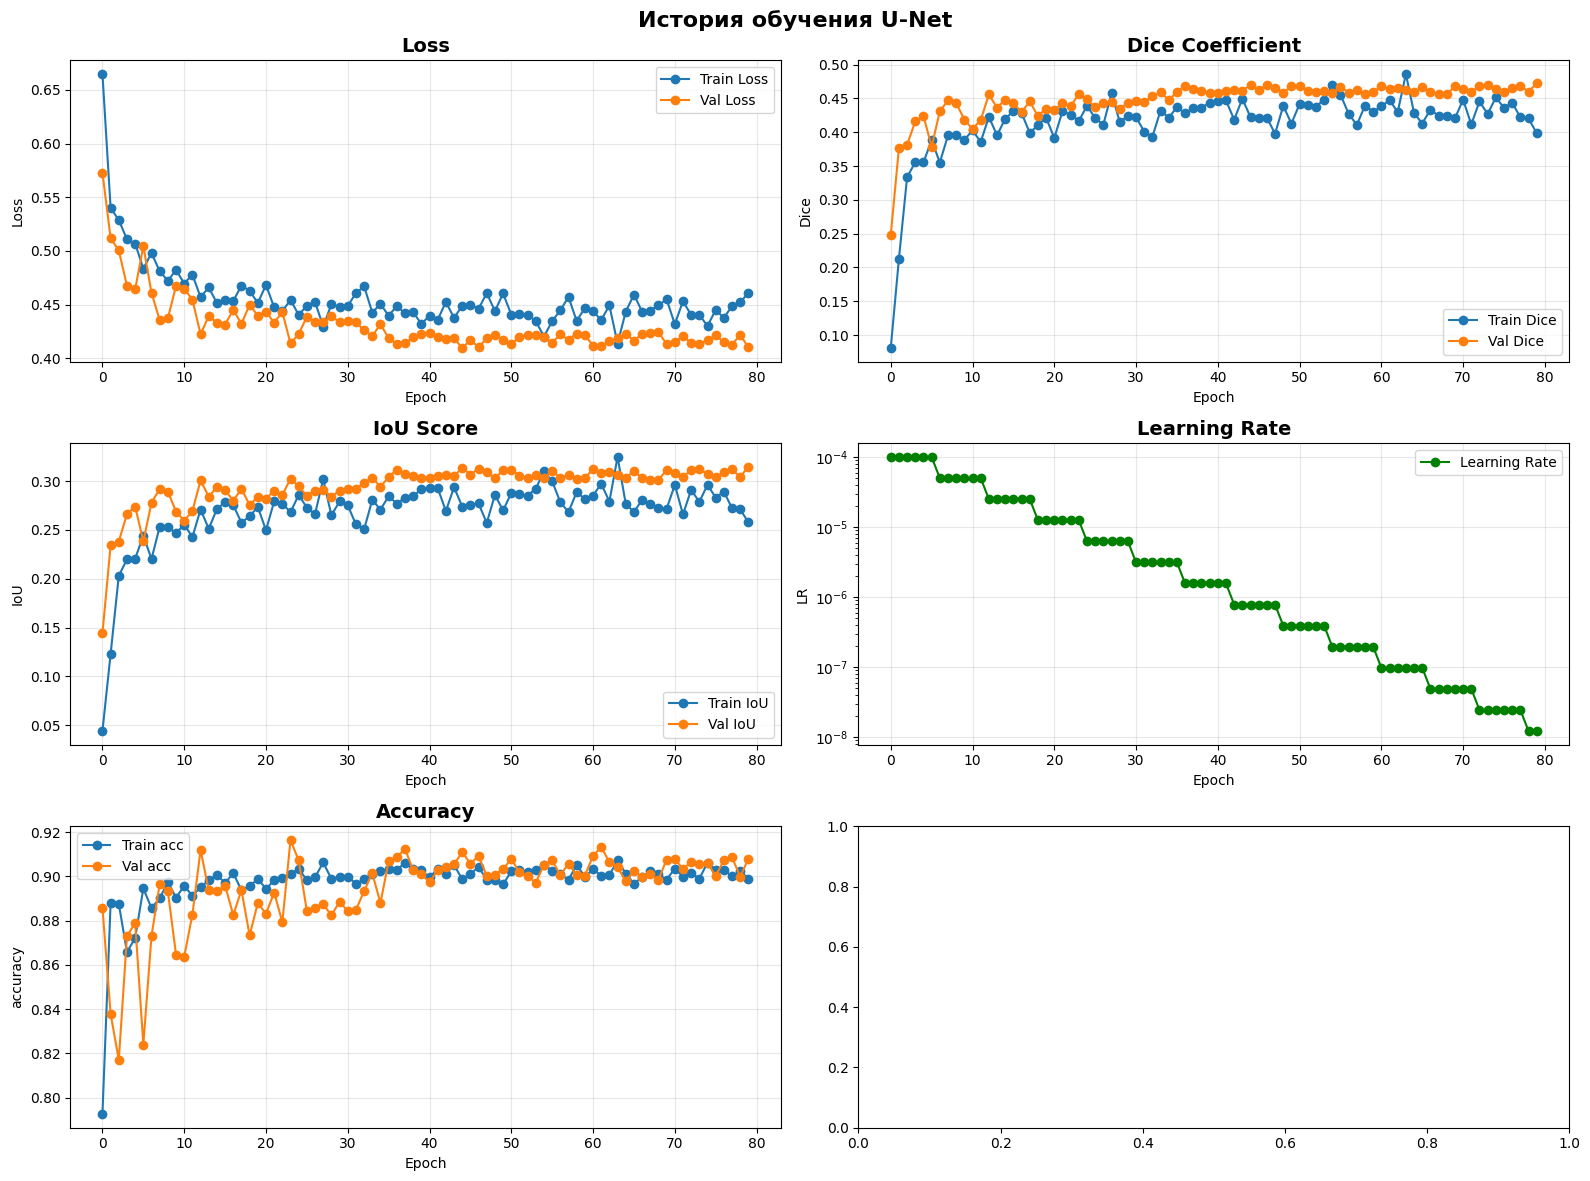

Train Loss: 0.4611
Val Loss: 0.4102
Train Dice: 0.3986
Val Dice: 0.4722
Train IoU: 0.2576
Val IoU: 0.3149
Val Accuracy: 0.9080


In [34]:
plot_training_history(my_unet_without_freeze_history)

c:\Users\User\anaconda3\envs\neural_networks\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


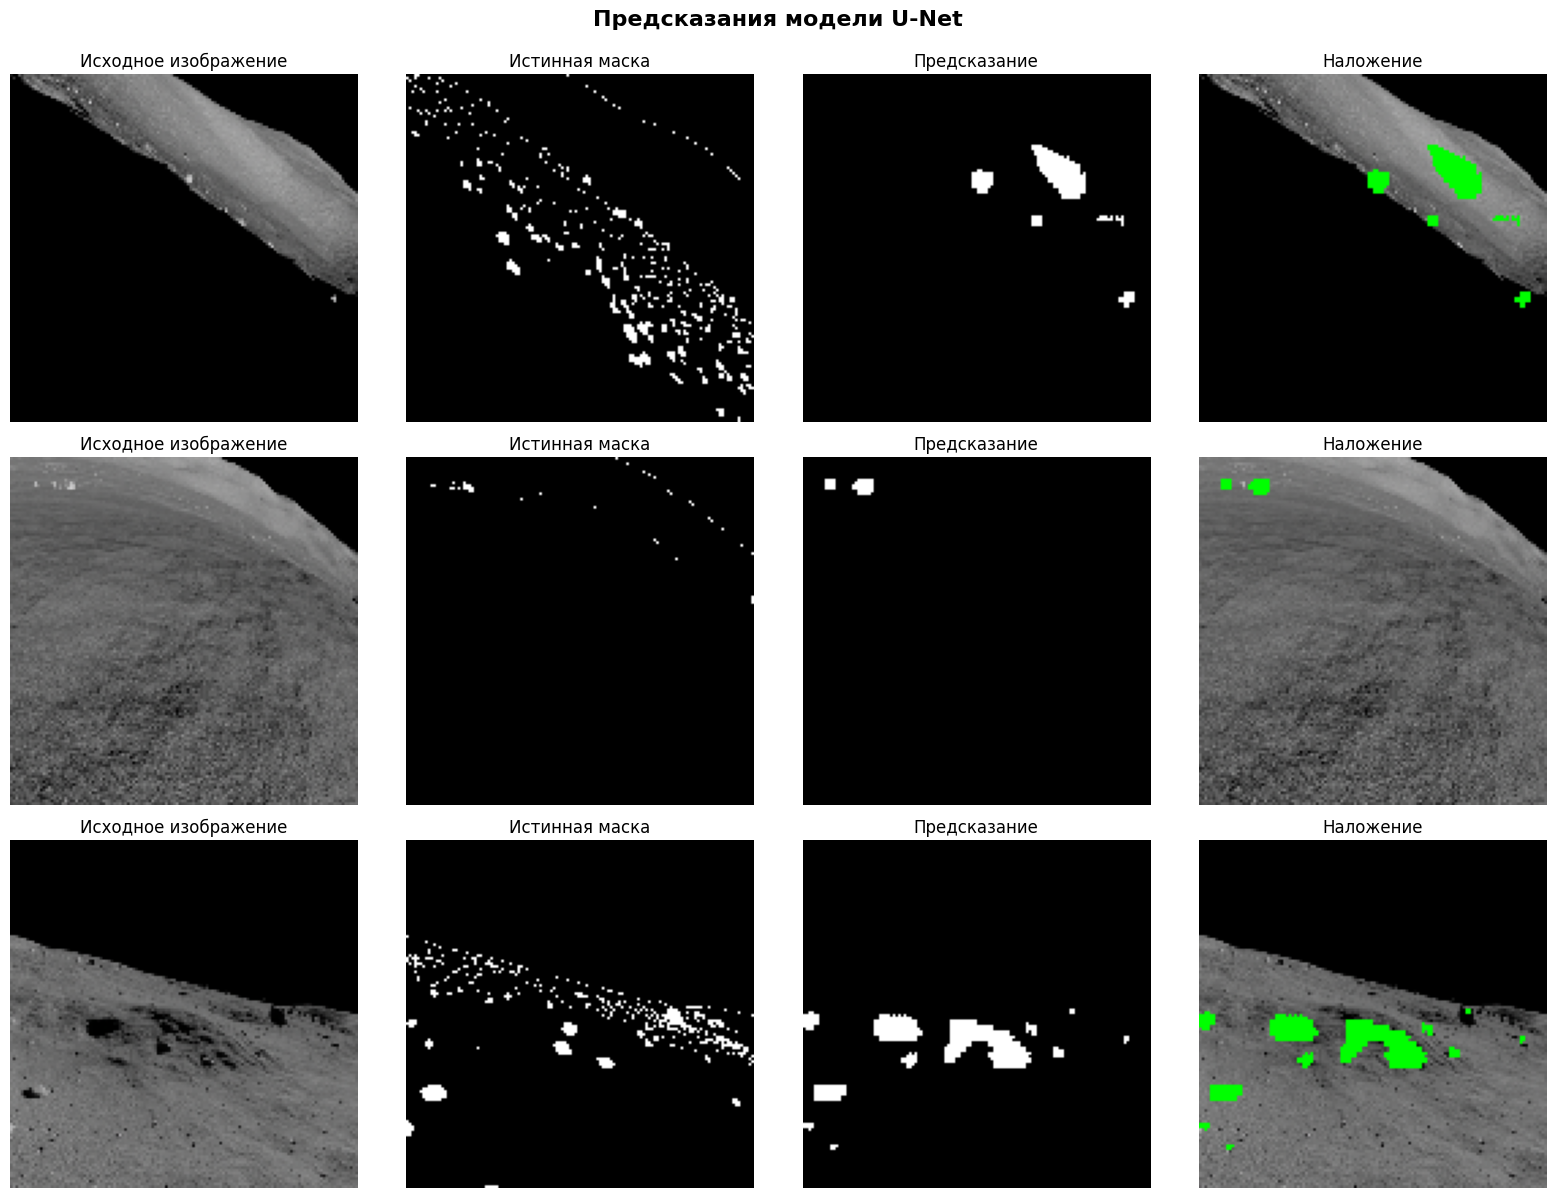

In [35]:
visualize_predictions(my_unet_without_freeze, val_loader, device, num_samples=3)

## Результаты

In [37]:
checkpoint_unet = torch.load('best_moon_unet.pth', map_location=device)


checkpoint_unet_freeze = torch.load('best_my_unet_freeze.pth', map_location=device)

checkpoint_unet_without_freeze = torch.load('best_my_unet_without_freeze.pth', map_location=device)

results = [
    {"Model": "Базовый UNet", "Epoch": checkpoint_unet['epoch'], "Dice": checkpoint_unet['val_dice'], "IoU": checkpoint_unet['val_iou']},
    {"Model": "A(энкодер заморожен)", "Epoch": checkpoint_unet_freeze['epoch'], "Dice": checkpoint_unet_freeze['val_dice'], "IoU": checkpoint_unet_freeze['val_iou']},
    {"Model": "B(энкодер разморожен)", "Epoch": checkpoint_unet_without_freeze['epoch'], "Dice": checkpoint_unet_without_freeze['val_dice'], "IoU": checkpoint_unet_without_freeze['val_iou']},
]

df = pd.DataFrame(results)
df

Model  Epoch      Dice       IoU
0           Базовый UNet     67  0.484395  0.323704
1   A(энкодер заморожен)     36  0.476022  0.316527
2  B(энкодер разморожен)     79  0.472236  0.314894

Все три модели показывают схожее качество: Dice = 0.47–0.48, IoU = 0.31–0.32.

Базовый U-Net (67 эпоха) демонстрирует лучший результат (Dice = 0.484).

Вариант A (замороженный энкодер) работает почти так же, но не превосходит базовую модель - предобученный энкодер без адаптации не даёт преимущества.

Вариант B (размороженный энкодер) не улучшил результат, несмотря на большее число эпох (79). Это может указывать на:

Недостаточную настройку гиперпараметров (например, слишком высокий LR для энкодера),
Переобучение,
Либо на то, что предобученный энкодер (на классификации изображений) не идеально переносится на задачу сегментации лунной поверхности.